In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import random
import time

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay, ModelBasedPrioritizedExperienceReplay
from experiment import Experiment
from dmlac import DMLAC
import nn
from exploration import EpsilonGreedyStrategy, OUStrategy
from ounoise import OUNoise

In [4]:
settings = dict(
    environment = 'MountainCarContinuous-v0',
    timesteps = 8000,
    max_replay_buffer_size = 100000,
    batch_size = 64,
    learning_start = 256,
    forward_steps = 1,
    discount_factor = 0.99,
    trace_decay = 0.9,
    
    actor_learning_rate=0.0001,
    model_learning_rate=0.001,
    reward_learning_rate=0.001,
    value_learning_rate=0.001,
    
    actor_l2=None,
    model_l2=None,
    reward_l2=None,
    value_l2=None,
    
    actor_target_approach_rate=0.99,
    value_target_approach_rate=0.99,
    
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.elu,
    actor_bounded_output = True,
    value_net_layers =  [256, 128],
    value_net_activation_fn = tf.nn.elu,
    model_net_embedding = 128,
    model_net_layers = [128],
    model_net_activation_fn = tf.nn.elu,
    reward_net_embedding = 128,
    reward_net_layers =  [128],
    reward_net_activation_fn = tf.nn.elu,
    
    environment_seed = 0,
    noise_seed= 0,
    
    gpu_memory_fraction = 0.1,
    
    render_environment = True,
    render_frequency = 10,
    render_start=7000,
)

settings["experiment_path"] = "experiments/experiment_dmlac_{}_{}".format(settings["environment"], int(time.time()))
settings["actor_tf_optimizer"] = tf.train.AdamOptimizer(settings["actor_learning_rate"])
settings["model_tf_optimizer"] = tf.train.AdamOptimizer(settings["model_learning_rate"])
settings["reward_tf_optimizer"] = tf.train.AdamOptimizer(settings["reward_learning_rate"])
settings["value_tf_optimizer"] = tf.train.AdamOptimizer(settings["value_learning_rate"])

print(settings["experiment_path"])

experiments/experiment_dmlac_MountainCarContinuous-v0_1495409405


In [5]:
def preprocess_state(observation):
    state = np.array(observation)
    if settings["environment"] == "MountainCarContinuous-v0":
        state[1] = state[1] * 10
        return state
    else:
        return state

def preprocess_reward(reward):
    return reward

In [6]:
env = gym.make(settings["environment"])
env.seed(settings["environment_seed"])

observation = preprocess_state(env.reset())
state = observation

[2017-05-22 01:30:05,805] Making new env: MountainCarContinuous-v0


In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

2
1
[ 0.6   0.07]
[-1.2  -0.07]
[ 1.]
[-1.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
summary_writer = tf.summary.FileWriter(settings["experiment_path"] + "/logdir")

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, False)
model_network = nn.fully_connected_with_input_embedding(
    "Model", session, [state_dim, action_dim], settings["model_net_embedding"], settings["model_net_layers"], state_dim,
     settings["model_net_activation_fn"], None, False)
reward_network = nn.fully_connected_with_input_embedding(
    "Reward", session, [state_dim, action_dim], settings["reward_net_embedding"], settings["reward_net_layers"], 1,
     settings["reward_net_activation_fn"], None, False)
value_network = nn.fully_connected("Value", session, [state_dim], settings["value_net_layers"], 1,
                               settings["value_net_activation_fn"], None, False)
print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output
['output'] --> bounding



In [10]:
agent = DMLAC(actor_network, model_network, reward_network, value_network,
                 forward_steps=settings["forward_steps"],
                 discount_factor=settings["discount_factor"],
                 trace_decay=settings["trace_decay"],
                 actor_tf_optimizer=settings["actor_tf_optimizer"],
                 model_tf_optimizer=settings["model_tf_optimizer"],
                 reward_tf_optimizer=settings["reward_tf_optimizer"],
                 value_tf_optimizer=settings["value_tf_optimizer"],
                 actor_l2=settings["actor_l2"],
                 model_l2=settings["model_l2"],
                 reward_l2=settings["reward_l2"],
                 value_l2=settings["value_l2"],
                 actor_target_approach_rate=settings["actor_target_approach_rate"],
                 value_target_approach_rate=settings["value_target_approach_rate"],
                 summary_writer=summary_writer
                )

In [11]:
saver = tf.train.Saver()
summary_writer.add_graph(session.graph)

In [12]:
experience_replay = ModelBasedPrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"], episodic=True)

In [13]:
noise = OUNoise(action_dim, seed=settings["noise_seed"])

In [14]:
exp = Experiment(settings["experiment_path"], session, env, settings, settings["render_environment"], settings["render_frequency"], settings["render_start"])

progress_bar = tqdm(total=settings["timesteps"])

e_t = -1
for t in xrange(settings["timesteps"]):
    e_t += 1
    if t < settings["learning_start"]:
        action = noise.noise()
    else:
        action = agent.action(state)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(preprocess_state(observation), (state_dim,))
    
    experience_replay.add_experience(state, action, preprocess_reward(reward), next_state, done)
    td_error = math.fabs(experience_replay.get_last_td_error())
    model_error = experience_replay.get_last_model_error()
    reward_error = experience_replay.get_last_reward_error()

    exp.record(t, state, action, reward, next_state, done, td_error, model_error, reward_error)
    
    state = next_state
    
    if done:
        exp.print_last_episode_info()
        observation = env.reset()
        state = preprocess_state(observation)
        e_t = -1
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, action: {}, td-error: {:.4f}, model error: {:.4f}, reward error: {:.4f}' \
        .format(t, reward, exp.reward_100ma.get_average(), str(action), td_error, model_error, reward_error))
    progress_bar.update()
    
        
progress_bar.close()

[174] reward: -0.00, reward 100-step MA: 0.98, action: [-0.07092898], td-error: 0.0000, model error: 0.0031, reward error: 2.0657:   2%|▏         | 175/8000 [00:01<06:54, 18.87it/s]    | 1/8000 [00:00<56:34,  2.36it/s]

Total episode reward: 96.4231978292. Finished in 130 steps.


[306] reward: -0.10, reward 100-step MA: -0.05, action: [ 0.98711097], td-error: 25.2040, model error: 0.0001, reward error: 618.8727:   4%|▍         | 307/8000 [00:10<15:50,  8.10it/s]] reward: -0.01, reward 100-step MA: -0.01, action: [-0.3637961], td-error: 0.0000, model error: 0.0507, reward error: 2.5737:   3%|▎         | 234/8000 [00:01<03:35, 36.09it/s]

Total episode reward: 93.5231650728. Finished in 179 steps.


[1695] reward: 99.91, reward 100-step MA: 0.92, action: [ 0.95290232], td-error: 134.8447, model error: 0.0000, reward error: 16067.3672:  21%|██        | 1696/8000 [04:35<20:29,  5.13it/s]] reward: -0.01, reward 100-step MA: 0.95, action: [ 0.23008931], td-error: 0.0000, model error: 0.0000, reward error: 6.6592:   4%|▍         | 321/8000 [00:12<18:29,  6.92it/s]

Total episode reward: -13.8869715649. Finished in 1387 steps.


[1819] reward: 99.99, reward 100-step MA: 0.85, action: [ 0.3119626], td-error: 782.9854, model error: 0.0024, reward error: 12847.1084:  23%|██▎       | 1820/8000 [04:59<19:57,  5.16it/s] [1697] reward: -0.02, reward 100-step MA: 0.92, action: [-0.41467035], td-error: 0.0000, model error: 0.0018, reward error: 154.1618:  21%|██        | 1698/8000 [04:35<20:14,  5.19it/s]

Total episode reward: 84.1286960661. Finished in 124 steps.


[2150] reward: 99.60, reward 100-step MA: 0.89, action: [ 1.98852909], td-error: 543.6807, model error: 0.0001, reward error: 1584.3918:  27%|██▋       | 2151/8000 [06:04<19:17,  5.05it/s][1821] reward: -0.05, reward 100-step MA: 0.85, action: [-0.71537304], td-error: 0.0000, model error: 0.0034, reward error: 1623.8997:  23%|██▎       | 1822/8000 [04:59<19:50,  5.19it/s]

Total episode reward: 63.6965154201. Finished in 331 steps.


[2314] reward: 99.90, reward 100-step MA: 0.94, action: [ 1.01177847], td-error: 0.0000, model error: 0.0017, reward error: 864.4659:  29%|██▉       | 2315/8000 [06:36<18:35,  5.10it/s]   [2152] reward: -0.01, reward 100-step MA: 0.89, action: [-0.34694254], td-error: 30.0261, model error: 0.0011, reward error: 3.0154:  27%|██▋       | 2153/8000 [06:04<19:12,  5.07it/s]

Total episode reward: 92.4477668174. Finished in 164 steps.


[2435] reward: 99.87, reward 100-step MA: 0.93, action: [ 1.15491557], td-error: 187.1152, model error: 0.0005, reward error: 59.9050:  30%|███       | 2436/8000 [07:00<18:21,  5.05it/s] 316] reward: -0.08, reward 100-step MA: 0.94, action: [ 0.89678347], td-error: 0.0000, model error: 0.0005, reward error: 23.1924:  29%|██▉       | 2317/8000 [06:37<19:20,  4.90it/s]

Total episode reward: 91.3727454161. Finished in 121 steps.


[2518] reward: 99.83, reward 100-step MA: 1.93, action: [ 1.29782808], td-error: 604.0186, model error: 0.0001, reward error: 4392.6660:  31%|███▏      | 2519/8000 [07:17<18:21,  4.97it/s]437] reward: -0.04, reward 100-step MA: 0.94, action: [-0.61635572], td-error: 0.0000, model error: 0.0013, reward error: 0.5953:  30%|███       | 2438/8000 [07:01<18:14,  5.08it/s] 

Total episode reward: 95.0047661277. Finished in 83 steps.


[2659] reward: 99.91, reward 100-step MA: 0.94, action: [ 0.94806051], td-error: 214.4082, model error: 0.0003, reward error: 622.4498:  33%|███▎      | 2660/8000 [07:45<17:38,  5.05it/s] [2520] reward: -0.08, reward 100-step MA: 1.93, action: [-0.90444177], td-error: 40.6895, model error: 0.0005, reward error: 0.0553:  32%|███▏      | 2521/8000 [07:17<18:14,  5.00it/s] 

Total episode reward: 91.8093924948. Finished in 141 steps.


[2735] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.99506879], td-error: 290.3008, model error: 0.0002, reward error: 399.9548:  34%|███▍      | 2736/8000 [08:00<17:22,  5.05it/s][2661] reward: -0.03, reward 100-step MA: 0.94, action: [-0.53973788], td-error: 0.0000, model error: 0.0021, reward error: 0.0532:  33%|███▎      | 2662/8000 [07:45<17:45,  5.01it/s]

Total episode reward: 94.5837537746. Finished in 76 steps.


[2879] reward: 99.91, reward 100-step MA: 0.95, action: [ 0.9718256], td-error: 942.3574, model error: 0.0000, reward error: 243.0125:  36%|███▌      | 2880/8000 [08:28<17:01,  5.01it/s]  2737] reward: -0.05, reward 100-step MA: 1.92, action: [-0.69772553], td-error: 12.2798, model error: 0.0004, reward error: 0.5264:  34%|███▍      | 2738/8000 [08:00<17:08,  5.12it/s]

Total episode reward: 93.6874602827. Finished in 144 steps.


[2954] reward: 99.90, reward 100-step MA: 1.93, action: [ 0.9912833], td-error: 801.2500, model error: 0.0001, reward error: 1121.4849:  37%|███▋      | 2955/8000 [08:43<16:56,  4.97it/s]2881] reward: -0.07, reward 100-step MA: 0.95, action: [-0.81734598], td-error: 3.5518, model error: 0.0003, reward error: 0.1470:  36%|███▌      | 2882/8000 [08:29<16:50,  5.06it/s]

Total episode reward: 95.2824589813. Finished in 75 steps.


[3099] reward: 99.90, reward 100-step MA: 0.95, action: [ 0.98041534], td-error: 1076.8770, model error: 0.0007, reward error: 272.2931:  39%|███▉      | 3100/8000 [09:12<16:34,  4.93it/s]2956] reward: -0.09, reward 100-step MA: 1.93, action: [-0.94886076], td-error: 46.8257, model error: 0.0001, reward error: 15.4871:  37%|███▋      | 2957/8000 [08:44<17:00,  4.94it/s]

Total episode reward: 93.7055666543. Finished in 145 steps.


[3180] reward: 99.90, reward 100-step MA: 1.93, action: [ 0.98563802], td-error: 284.2695, model error: 0.0007, reward error: 34.6130:  40%|███▉      | 3181/8000 [09:28<16:05,  4.99it/s]  [3101] reward: -0.14, reward 100-step MA: 0.95, action: [-1.16526079], td-error: 0.0000, model error: 0.0018, reward error: 0.0202:  39%|███▉      | 3102/8000 [09:13<16:19,  5.00it/s]  

Total episode reward: 94.8222190916. Finished in 81 steps.


[3255] reward: 99.90, reward 100-step MA: 1.93, action: [ 1.00092041], td-error: 1437.4727, model error: 0.0002, reward error: 5479.7212:  41%|████      | 3256/8000 [09:43<15:44,  5.02it/s]82] reward: -0.10, reward 100-step MA: 1.93, action: [-0.9911927], td-error: 12.9302, model error: 0.0002, reward error: 0.0260:  40%|███▉      | 3183/8000 [09:29<16:08,  4.97it/s]  

Total episode reward: 95.3206187029. Finished in 75 steps.


[3329] reward: -0.10, reward 100-step MA: 0.92, action: [ 0.99487031], td-error: 655.1602, model error: 0.0001, reward error: 40.0274:  42%|████▏     | 3330/8000 [09:58<15:33,  5.00it/s]   [3257] reward: -0.11, reward 100-step MA: 1.93, action: [-1.06746531], td-error: 19.7520, model error: 0.0000, reward error: 56.3410:  41%|████      | 3258/8000 [09:44<15:52,  4.98it/s] 

Total episode reward: 95.030240833. Finished in 75 steps.


[3409] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.98966575], td-error: 503.1699, model error: 0.0003, reward error: 188.7018:  43%|████▎     | 3410/8000 [10:14<15:28,  4.95it/s]][3331] reward: -0.09, reward 100-step MA: 1.92, action: [-0.94382316], td-error: 0.0000, model error: 0.0006, reward error: 0.9238:  42%|████▏     | 3332/8000 [09:59<15:43,  4.95it/s]     

Total episode reward: 94.5742948659. Finished in 79 steps.


[3483] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.97474086], td-error: 918.9492, model error: 0.0002, reward error: 6.7982:  44%|████▎     | 3484/8000 [10:29<15:09,  4.97it/s]  [3411] reward: -0.11, reward 100-step MA: 1.92, action: [-1.03424931], td-error: 139.5518, model error: 0.0000, reward error: 0.4133:  43%|████▎     | 3412/8000 [10:15<15:19,  4.99it/s]

Total episode reward: 95.0923479071. Finished in 74 steps.


[3631] reward: 99.90, reward 100-step MA: 0.95, action: [ 1.00145221], td-error: 902.7031, model error: 0.0004, reward error: 1497.1527:  45%|████▌     | 3632/8000 [10:59<14:49,  4.91it/s]85] reward: -0.10, reward 100-step MA: 1.92, action: [-0.98203981], td-error: 0.0000, model error: 0.0001, reward error: 0.2068:  44%|████▎     | 3486/8000 [10:30<15:10,  4.96it/s]

Total episode reward: 92.6124776109. Finished in 148 steps.


[3708] reward: 99.90, reward 100-step MA: 1.93, action: [ 0.97811317], td-error: 1086.6914, model error: 0.0006, reward error: 506.8153:  46%|████▋     | 3709/8000 [11:14<14:43,  4.86it/s][3633] reward: -0.11, reward 100-step MA: 0.95, action: [-1.02785206], td-error: 307.9521, model error: 0.0000, reward error: 27.7952:  45%|████▌     | 3634/8000 [10:59<14:56,  4.87it/s]

Total episode reward: 95.1492344202. Finished in 77 steps.


[3787] reward: 99.90, reward 100-step MA: 1.93, action: [ 0.99585497], td-error: 2309.5820, model error: 0.0005, reward error: 65.9612:  47%|████▋     | 3788/8000 [11:30<14:24,  4.87it/s] [3710] reward: -0.11, reward 100-step MA: 1.93, action: [-1.04609823], td-error: 256.3818, model error: 0.0000, reward error: 15.2844:  46%|████▋     | 3711/8000 [11:15<14:37,  4.89it/s]

Total episode reward: 94.8678545986. Finished in 79 steps.


[3949] reward: 99.90, reward 100-step MA: 0.94, action: [ 1.00653851], td-error: 1091.6953, model error: 0.0009, reward error: 582.3171:  49%|████▉     | 3950/8000 [12:03<13:59,  4.83it/s]  89] reward: -0.10, reward 100-step MA: 1.93, action: [-0.98602957], td-error: 307.8262, model error: 0.0001, reward error: 0.4177:  47%|████▋     | 3790/8000 [11:31<14:01,  5.00it/s]

Total episode reward: 90.3256358579. Finished in 162 steps.


[4029] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.98892784], td-error: 2208.8516, model error: 0.0003, reward error: 1473.5466:  50%|█████     | 4030/8000 [12:19<13:27,  4.91it/s]3951] reward: -0.11, reward 100-step MA: 0.94, action: [-1.06735146], td-error: 108.5859, model error: 0.0001, reward error: 6.5596:  49%|████▉     | 3952/8000 [12:03<13:45,  4.91it/s]

Total episode reward: 94.2026321658. Finished in 80 steps.


[4103] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.99534035], td-error: 1083.8281, model error: 0.0007, reward error: 339.0142:  51%|█████▏    | 4104/8000 [12:34<13:13,  4.91it/s] [4031] reward: -0.11, reward 100-step MA: 1.92, action: [-1.03191257], td-error: 35.2227, model error: 0.0001, reward error: 0.4022:  50%|█████     | 4032/8000 [12:20<13:18,  4.97it/s]

Total episode reward: 94.4505720697. Finished in 74 steps.


[4176] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.9959271], td-error: 4162.9219, model error: 0.0002, reward error: 1242.0801:  52%|█████▏    | 4177/8000 [12:49<12:38,  5.04it/s][4105] reward: -0.11, reward 100-step MA: 1.92, action: [-1.06371951], td-error: 100.0859, model error: 0.0001, reward error: 4.1703:  51%|█████▏    | 4106/8000 [12:35<13:03,  4.97it/s]

Total episode reward: 94.6139781381. Finished in 73 steps.


[4248] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.99742329], td-error: 3727.8125, model error: 0.0001, reward error: 209.8219:  53%|█████▎    | 4249/8000 [13:04<12:31,  4.99it/s][4178] reward: -0.11, reward 100-step MA: 1.92, action: [-1.04347324], td-error: 292.0566, model error: 0.0002, reward error: 0.3191:  52%|█████▏    | 4179/8000 [12:49<12:43,  5.00it/s]

Total episode reward: 94.5663274728. Finished in 72 steps.


[4319] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00802863], td-error: 2581.1562, model error: 0.0003, reward error: 226.0249:  54%|█████▍    | 4320/8000 [13:17<10:47,  5.69it/s][4250] reward: -0.12, reward 100-step MA: 1.92, action: [-1.10661185], td-error: 234.4160, model error: 0.0000, reward error: 0.5828:  53%|█████▎    | 4251/8000 [13:04<12:36,  4.95it/s]

Total episode reward: 94.3286504071. Finished in 71 steps.


[4394] reward: 99.90, reward 100-step MA: 1.92, action: [ 0.98692739], td-error: 3062.4141, model error: 0.0001, reward error: 36.8419:  55%|█████▍    | 4395/8000 [13:30<10:38,  5.65it/s] [4321] reward: -0.07, reward 100-step MA: 1.92, action: [-0.83494484], td-error: 0.0000, model error: 0.0001, reward error: 0.5059:  54%|█████▍    | 4322/8000 [13:17<10:42,  5.73it/s]

Total episode reward: 94.0069662674. Finished in 75 steps.


[4465] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.97635305], td-error: 3472.7969, model error: 0.0001, reward error: 0.1824:  56%|█████▌    | 4466/8000 [13:43<10:42,  5.50it/s] [4396] reward: -0.12, reward 100-step MA: 1.92, action: [-1.10470295], td-error: 358.2227, model error: 0.0000, reward error: 0.9168:  55%|█████▍    | 4397/8000 [13:31<10:29,  5.72it/s]

Total episode reward: 94.3249927012. Finished in 71 steps.


[4537] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.02158332], td-error: 1359.8125, model error: 0.0003, reward error: 143.6627:  57%|█████▋    | 4538/8000 [13:56<10:13,  5.64it/s]467] reward: -0.09, reward 100-step MA: 1.91, action: [-0.94578326], td-error: 0.0000, model error: 0.0002, reward error: 2.2365:  56%|█████▌    | 4468/8000 [13:43<10:40,  5.51it/s]  

Total episode reward: 94.1926985075. Finished in 72 steps.


[4609] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.98690319], td-error: 4752.4531, model error: 0.0000, reward error: 0.9344:  58%|█████▊    | 4610/8000 [14:08<09:56,  5.68it/s]  [4539] reward: -0.08, reward 100-step MA: 1.91, action: [-0.90795952], td-error: 47.3906, model error: 0.0002, reward error: 0.0458:  57%|█████▋    | 4540/8000 [13:56<10:08,  5.69it/s]  

Total episode reward: 94.0130174927. Finished in 72 steps.


[4680] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.98882532], td-error: 3905.5938, model error: 0.0002, reward error: 14.7974:  59%|█████▊    | 4681/8000 [14:21<09:46,  5.66it/s]4611] reward: -0.10, reward 100-step MA: 1.91, action: [-1.00080895], td-error: 0.0000, model error: 0.0003, reward error: 0.4150:  58%|█████▊    | 4612/8000 [14:09<09:55,  5.69it/s]  

Total episode reward: 93.7941235496. Finished in 71 steps.


[4750] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00387061], td-error: 5898.9062, model error: 0.0002, reward error: 19.8732:  59%|█████▉    | 4751/8000 [14:33<09:33,  5.67it/s][4682] reward: -0.11, reward 100-step MA: 1.91, action: [-1.02825725], td-error: 544.4648, model error: 0.0000, reward error: 0.0009:  59%|█████▊    | 4683/8000 [14:21<09:42,  5.70it/s]

Total episode reward: 93.7409767543. Finished in 70 steps.


[4821] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.98664117], td-error: 7844.2812, model error: 0.0001, reward error: 116.7266:  60%|██████    | 4822/8000 [14:46<09:18,  5.69it/s]4752] reward: -0.12, reward 100-step MA: 1.91, action: [-1.08858573], td-error: 1490.3945, model error: 0.0000, reward error: 7.6123:  59%|█████▉    | 4753/8000 [14:34<09:38,  5.61it/s]

Total episode reward: 94.101249705. Finished in 71 steps.


[4897] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.99818778], td-error: 8098.2188, model error: 0.0002, reward error: 0.3148:  61%|██████    | 4898/8000 [14:59<09:13,  5.60it/s]  [4823] reward: -0.10, reward 100-step MA: 1.91, action: [-1.02244425], td-error: 941.8750, model error: 0.0000, reward error: 1.5026:  60%|██████    | 4824/8000 [14:46<09:17,  5.70it/s]

Total episode reward: 93.3849713019. Finished in 76 steps.


[4973] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.99267745], td-error: 0.0000, model error: 0.0007, reward error: 209.5989:  62%|██████▏   | 4974/8000 [15:13<08:55,  5.65it/s]   899] reward: -0.10, reward 100-step MA: 1.91, action: [-1.01576245], td-error: 132.7969, model error: 0.0001, reward error: 2.7258:  61%|██████▏   | 4900/8000 [15:00<09:11,  5.63it/s]

Total episode reward: 93.1590904891. Finished in 76 steps.


[5045] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00971055], td-error: 725.8438, model error: 0.0005, reward error: 1.1238:  63%|██████▎   | 5046/8000 [15:26<08:55,  5.52it/s]   975] reward: -0.10, reward 100-step MA: 1.91, action: [-1.01912498], td-error: 1398.4453, model error: 0.0001, reward error: 0.0080:  62%|██████▏   | 4976/8000 [15:13<09:04,  5.56it/s]

Total episode reward: 93.8844160348. Finished in 72 steps.


[5118] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.9998523], td-error: 10294.0312, model error: 0.0001, reward error: 32.2812:  64%|██████▍   | 5119/8000 [15:39<08:37,  5.57it/s] 47] reward: -0.10, reward 100-step MA: 1.91, action: [-0.98514611], td-error: 0.0000, model error: 0.0002, reward error: 0.0349:  63%|██████▎   | 5048/8000 [15:26<08:55,  5.51it/s]  

Total episode reward: 93.4291041701. Finished in 73 steps.


[5189] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.99092078], td-error: 5854.1875, model error: 0.0003, reward error: 111.8748:  65%|██████▍   | 5190/8000 [15:51<08:20,  5.62it/s]5120] reward: -0.10, reward 100-step MA: 1.91, action: [-0.98187017], td-error: 981.4922, model error: 0.0000, reward error: 0.2890:  64%|██████▍   | 5121/8000 [15:39<08:30,  5.64it/s]

Total episode reward: 93.6595448984. Finished in 71 steps.


[5260] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00127995], td-error: 1309.2500, model error: 0.0006, reward error: 6.6576:  66%|██████▌   | 5261/8000 [16:04<08:06,  5.63it/s]  [5191] reward: -0.08, reward 100-step MA: 1.91, action: [-0.87972558], td-error: 533.0391, model error: 0.0001, reward error: 13.9041:  65%|██████▍   | 5192/8000 [15:52<08:15,  5.67it/s]

Total episode reward: 93.7073365383. Finished in 71 steps.


[5330] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.01399302], td-error: 5317.9688, model error: 0.0002, reward error: 0.5838:  67%|██████▋   | 5331/8000 [16:16<07:59,  5.57it/s]  262] reward: -0.06, reward 100-step MA: 1.91, action: [-0.78802913], td-error: 0.0000, model error: 0.0004, reward error: 0.4686:  66%|██████▌   | 5263/8000 [16:04<08:07,  5.62it/s] 

Total episode reward: 93.7653968748. Finished in 70 steps.


[5401] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.97575021], td-error: 24652.0000, model error: 0.0002, reward error: 101.4299:  68%|██████▊   | 5402/8000 [16:29<07:48,  5.54it/s]32] reward: -0.11, reward 100-step MA: 1.91, action: [-1.04186809], td-error: 2283.7578, model error: 0.0000, reward error: 0.0243:  67%|██████▋   | 5333/8000 [16:17<07:55,  5.61it/s]

Total episode reward: 93.6519493879. Finished in 71 steps.


[5497] reward: 99.99, reward 100-step MA: 1.94, action: [ 0.33883393], td-error: 0.0000, model error: 0.0002, reward error: 3022.5708:  69%|██████▊   | 5498/8000 [16:46<07:26,  5.60it/s]   [5403] reward: -0.02, reward 100-step MA: 1.91, action: [-0.42040992], td-error: 0.0000, model error: 0.0000, reward error: 0.3995:  68%|██████▊   | 5404/8000 [16:29<07:46,  5.57it/s]

Total episode reward: 94.2030324598. Finished in 96 steps.


[5569] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.99711835], td-error: 19448.1875, model error: 0.0001, reward error: 64.4392:  70%|██████▉   | 5570/8000 [16:59<07:16,  5.57it/s]499] reward: -0.05, reward 100-step MA: 1.94, action: [-0.70899582], td-error: 0.0000, model error: 0.0001, reward error: 4.5246:  69%|██████▉   | 5500/8000 [16:46<07:24,  5.62it/s]

Total episode reward: 93.5501463559. Finished in 72 steps.


[5642] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.021644], td-error: 17567.5625, model error: 0.0001, reward error: 49.9054:  71%|███████   | 5643/8000 [17:12<07:02,  5.58it/s]  [5571] reward: -0.11, reward 100-step MA: 1.91, action: [-1.02588367], td-error: 3794.4844, model error: 0.0000, reward error: 1.4887:  70%|██████▉   | 5572/8000 [16:59<07:12,  5.62it/s]

Total episode reward: 93.389277264. Finished in 73 steps.


[5715] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.99834955], td-error: 16039.4375, model error: 0.0000, reward error: 16.5300:  71%|███████▏  | 5716/8000 [17:25<06:47,  5.61it/s]644] reward: -0.04, reward 100-step MA: 1.91, action: [-0.62854755], td-error: 0.0000, model error: 0.0000, reward error: 0.0202:  71%|███████   | 5645/8000 [17:12<07:00,  5.59it/s]   

Total episode reward: 93.380181634. Finished in 73 steps.


[5787] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00111783], td-error: 39353.5000, model error: 0.0004, reward error: 79.6178:  72%|███████▏  | 5788/8000 [17:38<06:38,  5.55it/s][5717] reward: -0.11, reward 100-step MA: 1.91, action: [-1.05010939], td-error: 0.0000, model error: 0.0009, reward error: 0.0698:  71%|███████▏  | 5718/8000 [17:25<06:47,  5.59it/s]   

Total episode reward: 93.339612244. Finished in 72 steps.


[5859] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00086856], td-error: 17437.3125, model error: 0.0001, reward error: 0.3788:  73%|███████▎  | 5860/8000 [17:51<06:27,  5.52it/s] [5789] reward: -0.09, reward 100-step MA: 1.91, action: [-0.93721908], td-error: 1578.4375, model error: 0.0000, reward error: 2.3280:  72%|███████▏  | 5790/8000 [17:38<06:33,  5.62it/s]

Total episode reward: 93.4486696729. Finished in 72 steps.


[5931] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00103521], td-error: 20909.2500, model error: 0.0002, reward error: 0.1838:  74%|███████▍  | 5932/8000 [18:04<06:10,  5.59it/s] 5861] reward: -0.00, reward 100-step MA: 1.91, action: [-0.22270525], td-error: 0.0000, model error: 0.0000, reward error: 0.1423:  73%|███████▎  | 5862/8000 [17:51<06:28,  5.51it/s]

Total episode reward: 93.4269928606. Finished in 72 steps.


[6002] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.00126088], td-error: 23932.3750, model error: 0.0001, reward error: 0.0883:  75%|███████▌  | 6003/8000 [18:16<06:08,  5.42it/s] 5933] reward: -0.11, reward 100-step MA: 1.91, action: [-1.04868412], td-error: 4970.4219, model error: 0.0001, reward error: 0.1952:  74%|███████▍  | 5934/8000 [18:04<06:12,  5.55it/s]

Total episode reward: 93.3333530103. Finished in 71 steps.


[6114] reward: 99.90, reward 100-step MA: 0.92, action: [ 1.01420605], td-error: 23040.3750, model error: 0.0004, reward error: 2.1225:  76%|███████▋  | 6115/8000 [18:36<05:38,  5.58it/s]  004] reward: -0.01, reward 100-step MA: 1.91, action: [-0.27053785], td-error: 0.0000, model error: 0.0001, reward error: 5.3422:  75%|███████▌  | 6005/8000 [18:17<06:10,  5.39it/s]

Total episode reward: 91.6741434448. Finished in 112 steps.


[6188] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.98921239], td-error: 25949.4375, model error: 0.0003, reward error: 75.4884:  77%|███████▋  | 6189/8000 [18:50<05:29,  5.50it/s]6116] reward: -0.03, reward 100-step MA: 0.92, action: [-0.51721132], td-error: 0.0000, model error: 0.0000, reward error: 7.7200:  76%|███████▋  | 6117/8000 [18:37<05:41,  5.51it/s]

Total episode reward: 93.5686943771. Finished in 74 steps.


[6260] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.01850045], td-error: 38120.8750, model error: 0.0000, reward error: 78.2413:  78%|███████▊  | 6261/8000 [19:03<05:10,  5.60it/s][6190] reward: -0.11, reward 100-step MA: 1.91, action: [-1.03821003], td-error: 4561.7812, model error: 0.0000, reward error: 0.6163:  77%|███████▋  | 6191/8000 [18:50<05:28,  5.50it/s]

Total episode reward: 93.1345810918. Finished in 72 steps.


[6331] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.9989115], td-error: 39253.7500, model error: 0.0001, reward error: 3.2541:  79%|███████▉  | 6332/8000 [19:16<05:00,  5.55it/s]  [6262] reward: -0.05, reward 100-step MA: 1.90, action: [-0.70389664], td-error: 0.0000, model error: 0.0001, reward error: 0.2201:  78%|███████▊  | 6263/8000 [19:03<05:10,  5.60it/s]

Total episode reward: 93.4222280927. Finished in 71 steps.


[6403] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.97811031], td-error: 22837.6250, model error: 0.0001, reward error: 1650.8687:  80%|████████  | 6404/8000 [19:29<04:50,  5.50it/s]3] reward: -0.09, reward 100-step MA: 1.91, action: [-0.93731892], td-error: 2974.4062, model error: 0.0002, reward error: 2.7135:  79%|███████▉  | 6334/8000 [19:16<04:58,  5.58it/s]

Total episode reward: 93.3922931207. Finished in 72 steps.


[6474] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00635314], td-error: 18923.6250, model error: 0.0005, reward error: 12.2901:  81%|████████  | 6475/8000 [19:41<04:34,  5.55it/s]  [6405] reward: -0.09, reward 100-step MA: 1.91, action: [-0.94413006], td-error: 178.2500, model error: 0.0000, reward error: 2.6618:  80%|████████  | 6406/8000 [19:29<04:49,  5.51it/s]

Total episode reward: 93.4017595511. Finished in 71 steps.


[6545] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.00275207], td-error: 32210.8750, model error: 0.0002, reward error: 67.2621:  82%|████████▏ | 6546/8000 [19:54<04:23,  5.51it/s][6476] reward: -0.10, reward 100-step MA: 1.91, action: [-1.01411188], td-error: 4951.7812, model error: 0.0000, reward error: 0.2380:  81%|████████  | 6477/8000 [19:42<04:32,  5.58it/s]

Total episode reward: 93.2676075274. Finished in 71 steps.


[6617] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.00184715], td-error: 0.0000, model error: 0.0021, reward error: 9.8404:  83%|████████▎ | 6618/8000 [20:07<04:09,  5.54it/s]     [6547] reward: -0.10, reward 100-step MA: 1.90, action: [-1.01907206], td-error: 2401.1875, model error: 0.0004, reward error: 0.0280:  82%|████████▏ | 6548/8000 [19:55<04:23,  5.51it/s] 

Total episode reward: 93.2235003289. Finished in 72 steps.


[6689] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.00427401], td-error: 30074.0000, model error: 0.0003, reward error: 2516.7756:  84%|████████▎ | 6690/8000 [20:20<03:58,  5.49it/s]reward: -0.10, reward 100-step MA: 1.90, action: [-1.02055562], td-error: 12882.8125, model error: 0.0002, reward error: 0.7609:  83%|████████▎ | 6620/8000 [20:08<04:05,  5.61it/s]

Total episode reward: 93.3046003025. Finished in 72 steps.


[6764] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00379801], td-error: 299299.5000, model error: 0.0065, reward error: 53.2323:  85%|████████▍ | 6765/8000 [20:34<03:46,  5.45it/s] [6691] reward: -0.01, reward 100-step MA: 1.91, action: [-0.32090044], td-error: 0.0000, model error: 0.0000, reward error: 0.2007:  84%|████████▎ | 6692/8000 [20:21<03:55,  5.56it/s]   

Total episode reward: 93.7202089961. Finished in 75 steps.


[6835] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.01534021], td-error: 0.0000, model error: 0.0011, reward error: 0.6105:  85%|████████▌ | 6836/8000 [20:47<03:35,  5.39it/s]      [6766] reward: -0.07, reward 100-step MA: 1.91, action: [-0.86211205], td-error: 0.0000, model error: 0.0005, reward error: 0.0259:  85%|████████▍ | 6767/8000 [20:34<03:45,  5.46it/s]

Total episode reward: 93.3041615159. Finished in 71 steps.


[6940] reward: 99.90, reward 100-step MA: 0.91, action: [ 1.00993085], td-error: 19347.2500, model error: 0.0003, reward error: 155.5727:  87%|████████▋ | 6941/8000 [21:06<03:14,  5.45it/s] reward: -0.01, reward 100-step MA: 1.91, action: [ 0.25121629], td-error: 0.0000, model error: 0.0000, reward error: 0.0066:  85%|████████▌ | 6838/8000 [20:47<03:31,  5.49it/s]

Total episode reward: 91.0947722998. Finished in 105 steps.


[7045] reward: 99.90, reward 100-step MA: 0.90, action: [ 0.99838042], td-error: 0.0000, model error: 0.0011, reward error: 42.3520:  88%|████████▊ | 7046/8000 [21:26<02:55,  5.45it/s]      6942] reward: -0.02, reward 100-step MA: 0.91, action: [ 0.4990654], td-error: 0.0000, model error: 0.0001, reward error: 1.5038:  87%|████████▋ | 6943/8000 [21:06<03:12,  5.50it/s]    

Total episode reward: 90.2636806126. Finished in 105 steps.


[7154] reward: 99.89, reward 100-step MA: 0.91, action: [ 1.03434765], td-error: 28368.2500, model error: 0.0016, reward error: 3.0978:  89%|████████▉ | 7155/8000 [21:46<02:35,  5.42it/s]   7] reward: -0.01, reward 100-step MA: 0.91, action: [ 0.35400629], td-error: 0.0000, model error: 0.0001, reward error: 1.9994:  88%|████████▊ | 7048/8000 [21:26<02:52,  5.53it/s]   

Total episode reward: 90.5581873064. Finished in 109 steps.


[7231] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.00807548], td-error: 28910.0000, model error: 0.0004, reward error: 28.0701:  90%|█████████ | 7232/8000 [22:00<02:21,  5.41it/s]7156] reward: -0.00, reward 100-step MA: 0.91, action: [ 0.16145456], td-error: 0.0000, model error: 0.0000, reward error: 3.0972:  89%|████████▉ | 7157/8000 [21:46<02:32,  5.52it/s]

Total episode reward: 92.2672517492. Finished in 77 steps.


[7339] reward: 99.90, reward 100-step MA: 0.92, action: [ 0.97473192], td-error: 83867.0000, model error: 0.0004, reward error: 59.1217:  92%|█████████▏| 7340/8000 [22:20<02:01,  5.41it/s] 7233] reward: -0.06, reward 100-step MA: 1.90, action: [ 0.77996969], td-error: 11150.1250, model error: 0.0001, reward error: 0.0113:  90%|█████████ | 7234/8000 [22:00<02:21,  5.42it/s]

Total episode reward: 90.9824652727. Finished in 108 steps.


[7415] reward: 99.90, reward 100-step MA: 1.91, action: [ 1.00547302], td-error: 45716.2500, model error: 0.0003, reward error: 4.2762:  93%|█████████▎| 7416/8000 [22:34<01:47,  5.42it/s] [7341] reward: -0.01, reward 100-step MA: 0.92, action: [ 0.24372602], td-error: 0.0000, model error: 0.0000, reward error: 0.7508:  92%|█████████▏| 7342/8000 [22:20<02:00,  5.44it/s]

Total episode reward: 93.4434528524. Finished in 76 steps.


[7522] reward: 99.90, reward 100-step MA: 0.92, action: [ 1.00021493], td-error: 65563.0000, model error: 0.0004, reward error: 77.1325:  94%|█████████▍| 7523/8000 [22:53<01:27,  5.46it/s] 417] reward: -0.03, reward 100-step MA: 1.91, action: [ 0.54996085], td-error: 0.0000, model error: 0.0001, reward error: 0.1301:  93%|█████████▎| 7418/8000 [22:34<01:48,  5.38it/s]

Total episode reward: 91.3302062892. Finished in 107 steps.


[7595] reward: 99.90, reward 100-step MA: 1.90, action: [ 1.00071621], td-error: 53430.5000, model error: 0.0005, reward error: 7.6382:  95%|█████████▍| 7596/8000 [23:07<01:14,  5.40it/s] [7524] reward: -0.03, reward 100-step MA: 0.92, action: [-0.51825792], td-error: 0.0000, model error: 0.0007, reward error: 0.0562:  94%|█████████▍| 7525/8000 [22:54<01:26,  5.52it/s]

Total episode reward: 92.8676053751. Finished in 73 steps.


[7668] reward: 99.90, reward 100-step MA: 1.90, action: [ 0.97726476], td-error: 14471.0000, model error: 0.0007, reward error: 0.0863:  96%|█████████▌| 7669/8000 [23:20<01:01,  5.42it/s] 7597] reward: -0.01, reward 100-step MA: 1.90, action: [-0.3307277], td-error: 0.0000, model error: 0.0001, reward error: 0.2370:  95%|█████████▍| 7598/8000 [23:07<01:13,  5.45it/s] 

Total episode reward: 92.749057066. Finished in 73 steps.


[7776] reward: 99.90, reward 100-step MA: 0.91, action: [ 1.01603138], td-error: 53074.0000, model error: 0.0010, reward error: 0.2535:  97%|█████████▋| 7777/8000 [23:40<00:41,  5.38it/s]   70] reward: -0.02, reward 100-step MA: 1.90, action: [ 0.40066624], td-error: 0.0000, model error: 0.0002, reward error: 0.6419:  96%|█████████▌| 7671/8000 [23:20<01:00,  5.40it/s]

Total episode reward: 90.8966227119. Finished in 108 steps.


[7849] reward: 99.90, reward 100-step MA: 1.91, action: [ 0.9964174], td-error: 66853.5000, model error: 0.0006, reward error: 41.5829:  98%|█████████▊| 7850/8000 [23:53<00:24,  6.07it/s] 7778] reward: -0.03, reward 100-step MA: 0.91, action: [-0.56303269], td-error: 6170.7500, model error: 0.0000, reward error: 0.2120:  97%|█████████▋| 7779/8000 [23:40<00:41,  5.38it/s]

Total episode reward: 93.4664236065. Finished in 73 steps.


[7960] reward: 99.90, reward 100-step MA: 0.91, action: [ 0.99759507], td-error: 67824.0000, model error: 0.0005, reward error: 27.7434: 100%|█████████▉| 7961/8000 [24:11<00:06,  5.88it/s]  51] reward: -0.01, reward 100-step MA: 1.91, action: [ 0.24447751], td-error: 0.0000, model error: 0.0000, reward error: 1.6037:  98%|█████████▊| 7852/8000 [23:53<00:24,  6.03it/s]

Total episode reward: 90.7968656336. Finished in 111 steps.


[7999] reward: -0.00, reward 100-step MA: 0.91, action: [ 0.14601552], td-error: 0.0000, model error: 0.0001, reward error: 0.0480: 100%|██████████| 8000/8000 [24:18<00:00,  6.17it/s]     [7962] reward: -0.00, reward 100-step MA: 0.92, action: [-0.17932951], td-error: 0.0000, model error: 0.0002, reward error: 2.0172: 100%|█████████▉| 7963/8000 [24:11<00:06,  5.89it/s]


In [15]:
exp.save()
print("Experiment results saved in " + exp.path)

Experiment results saved in experiments/experiment_dmlac_MountainCarContinuous-v0_1495409405


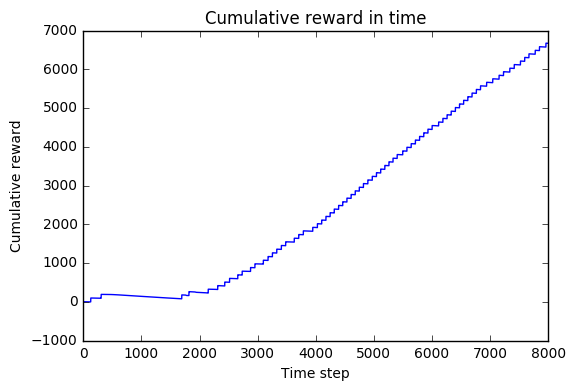

In [16]:
exp.plot_cumulative_reward()

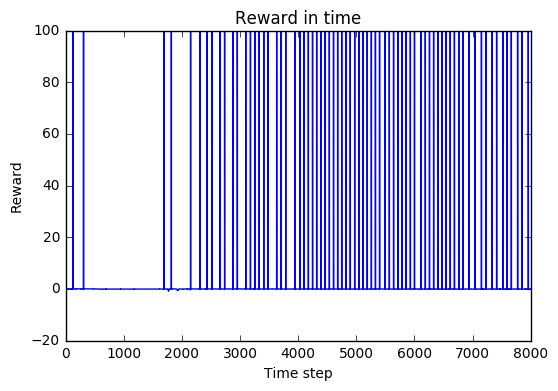

In [17]:
exp.plot_reward()

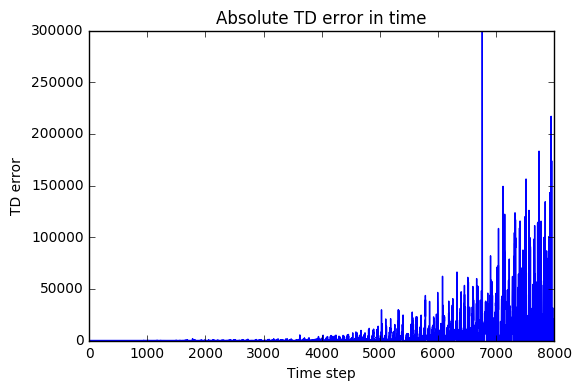

In [18]:
exp.plot_td_error()

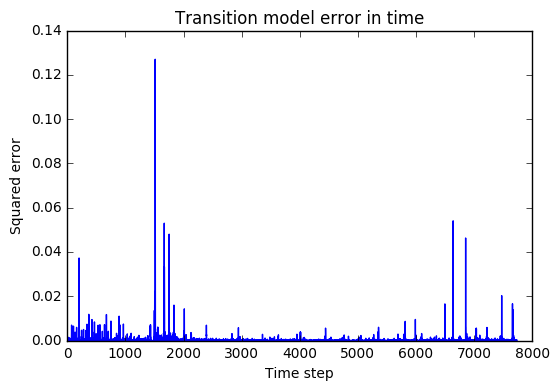

In [19]:
exp.plot_model_error(skip_steps=settings["learning_start"]+10)

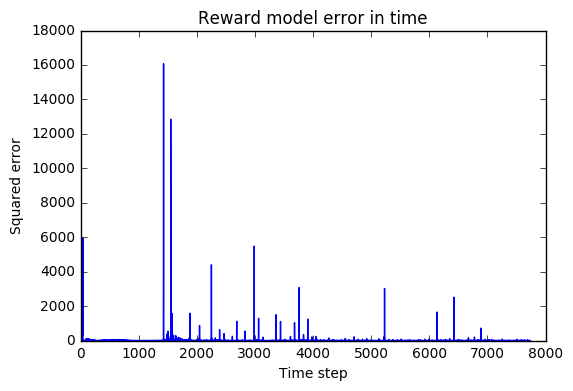

In [20]:
exp.plot_reward_error(skip_steps=settings["learning_start"]+10)

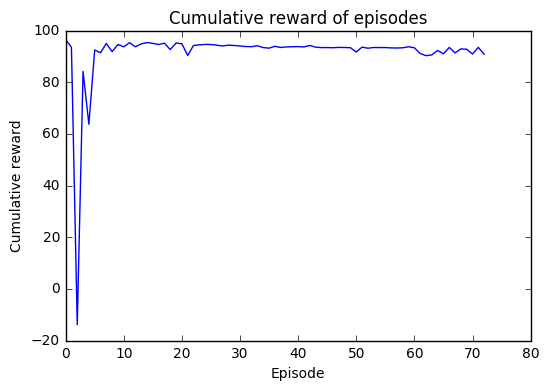

In [21]:
exp.plot_episode_reward()

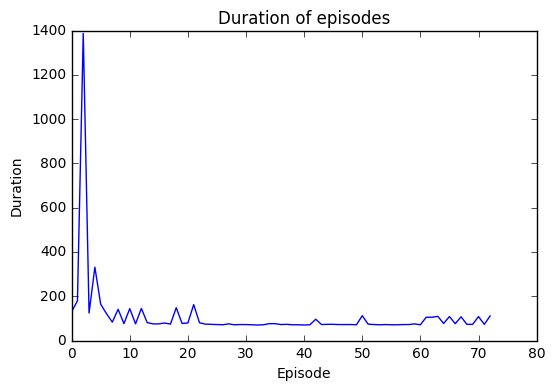

In [22]:
exp.plot_episode_duration()


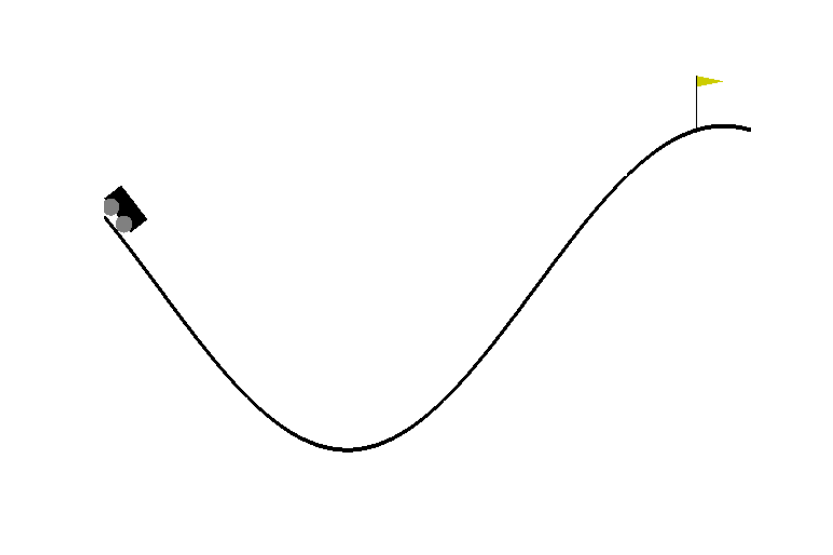
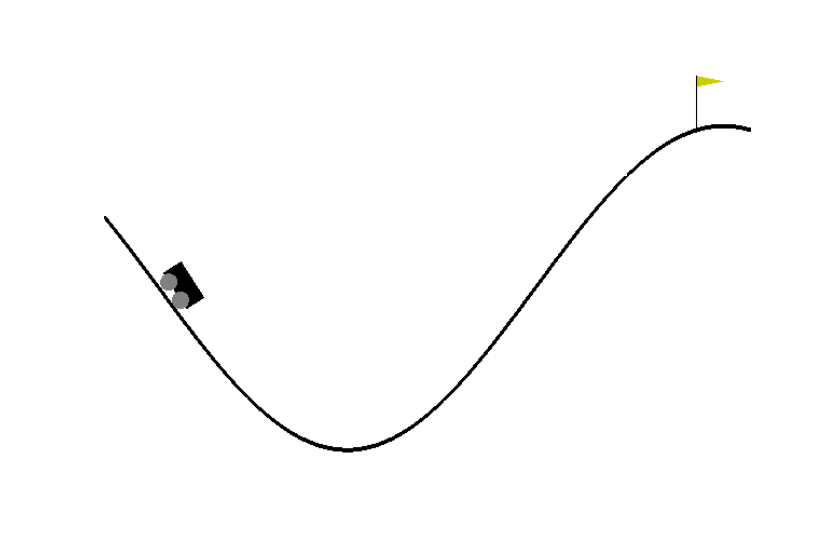
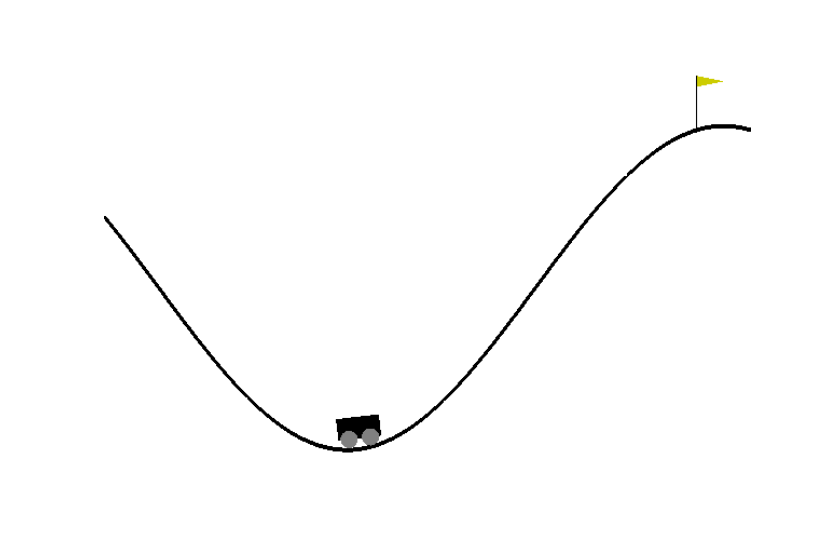
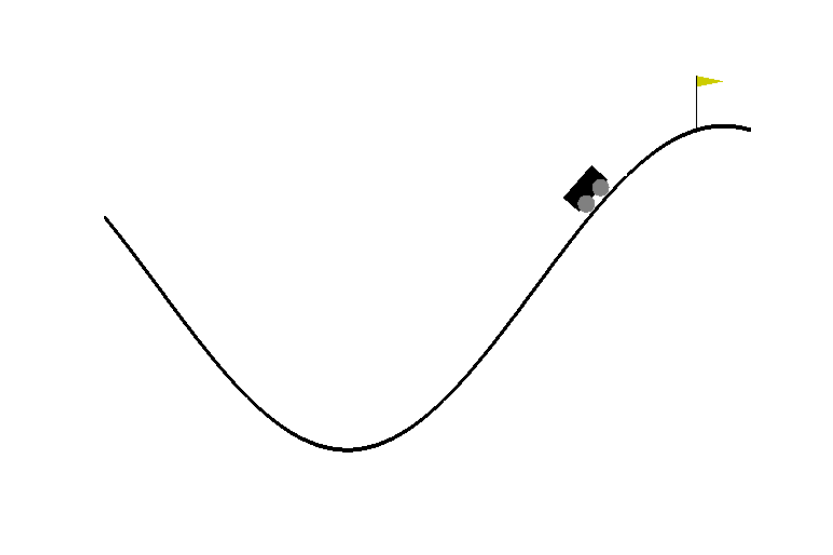
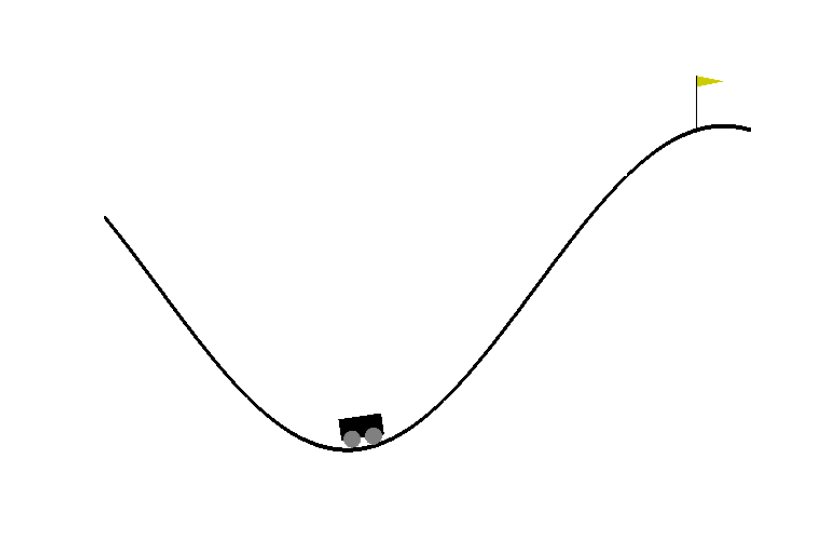
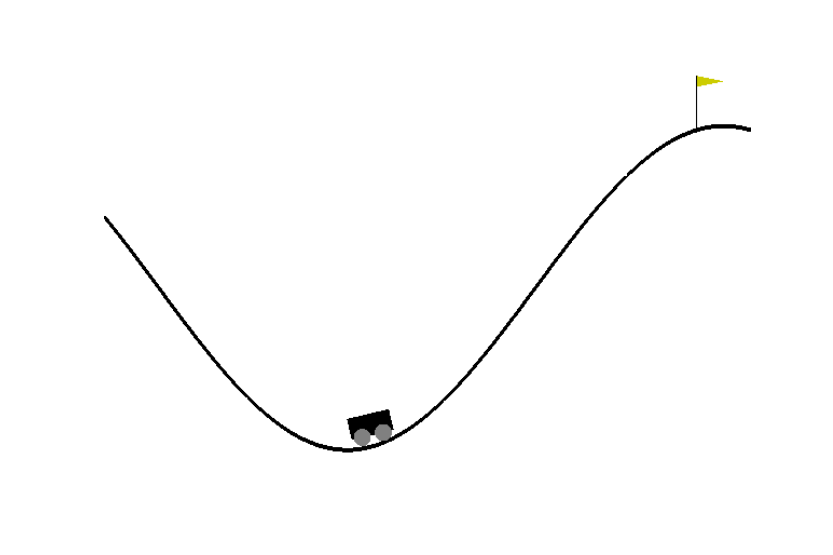
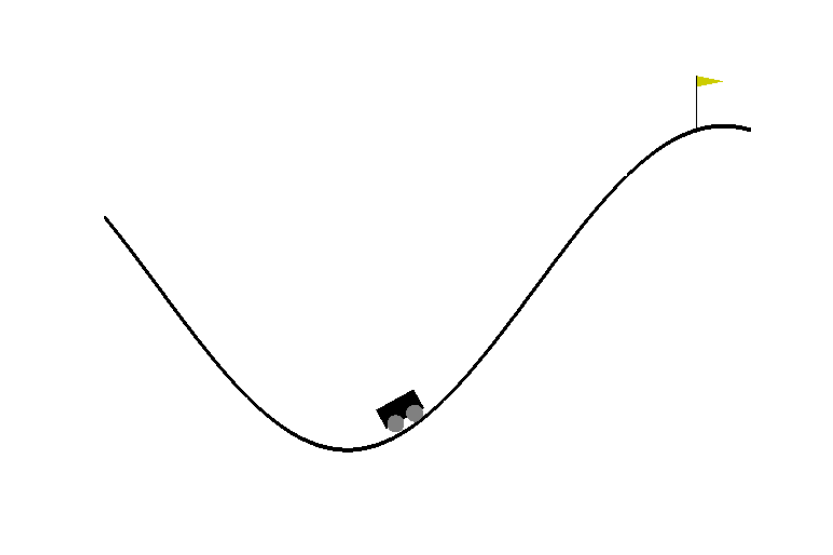
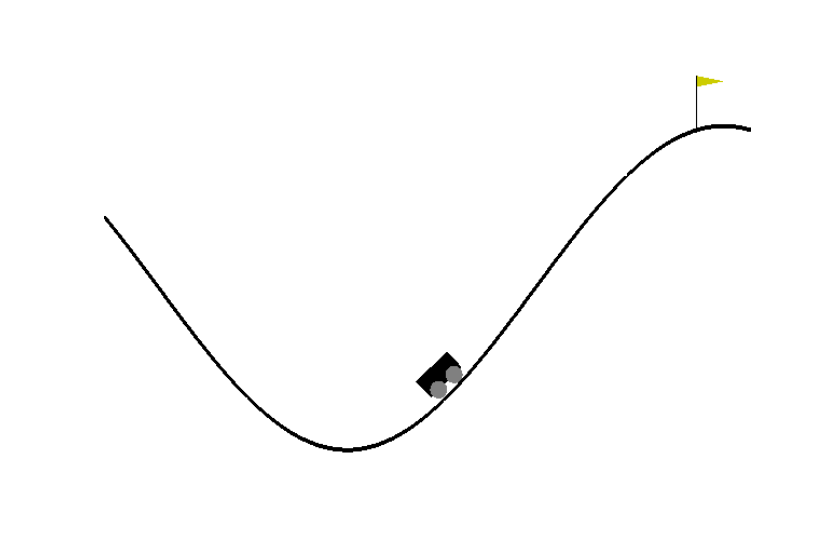
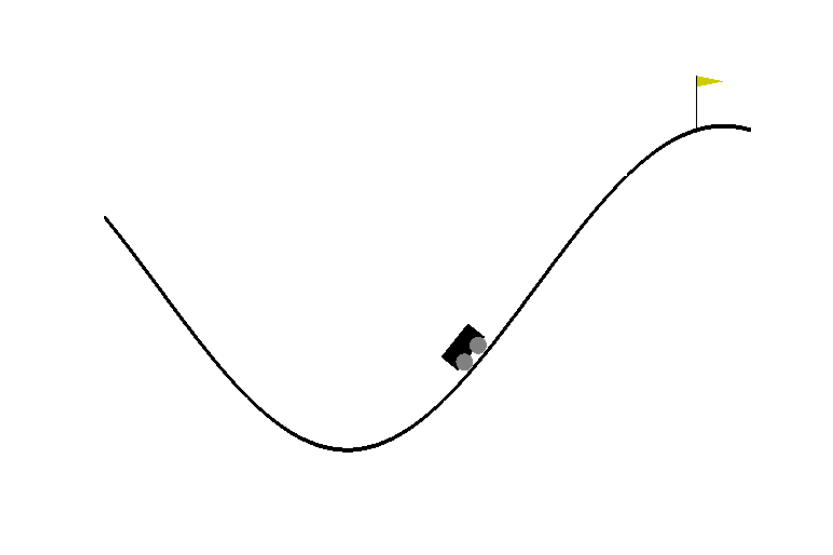
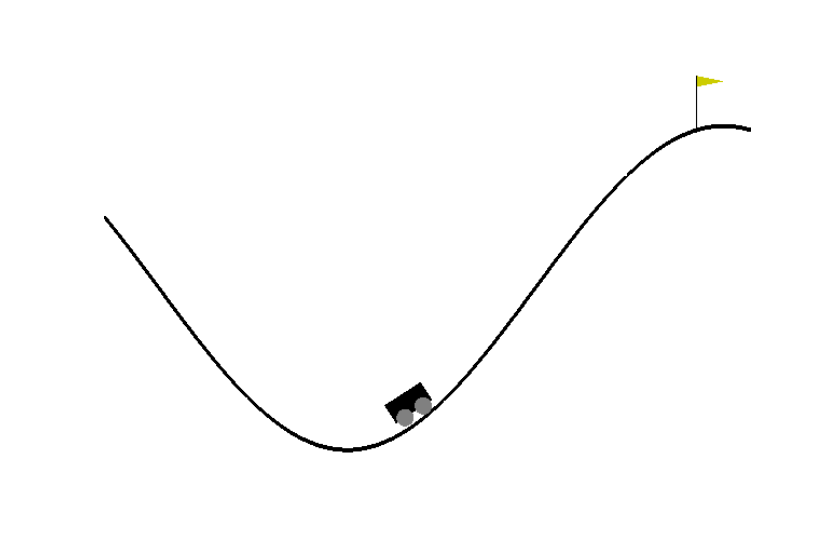
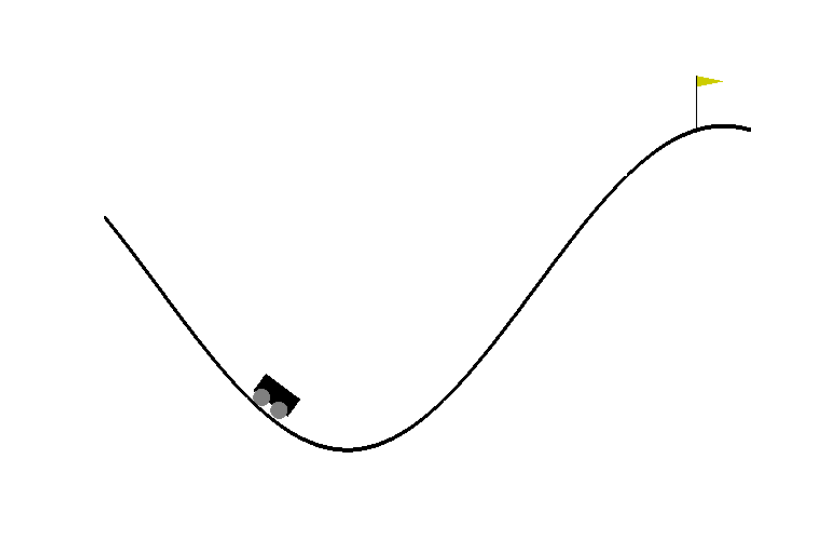
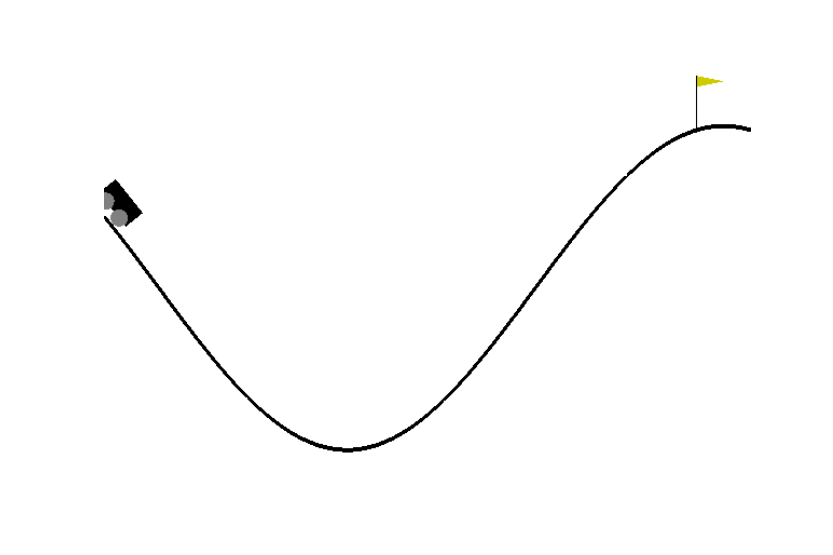
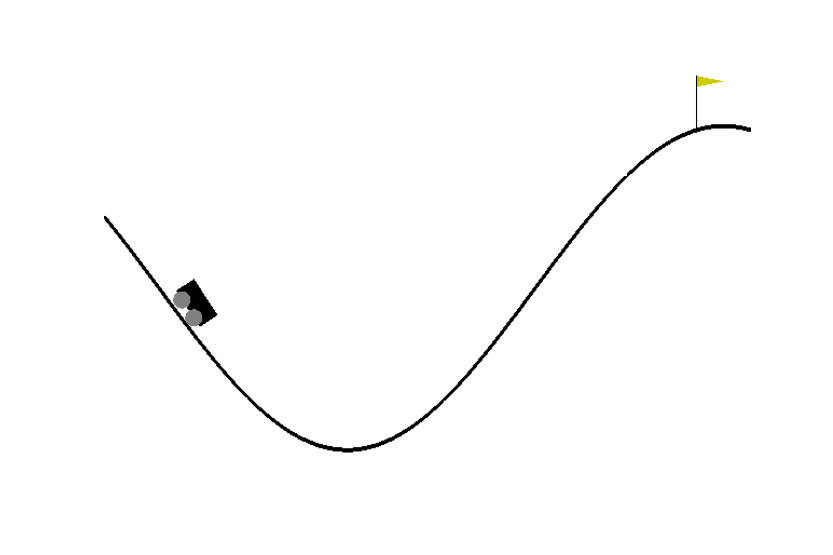
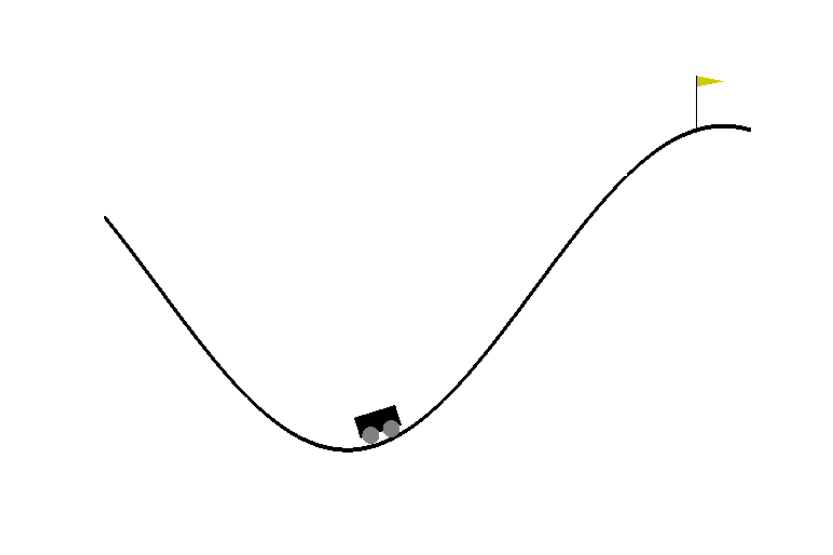
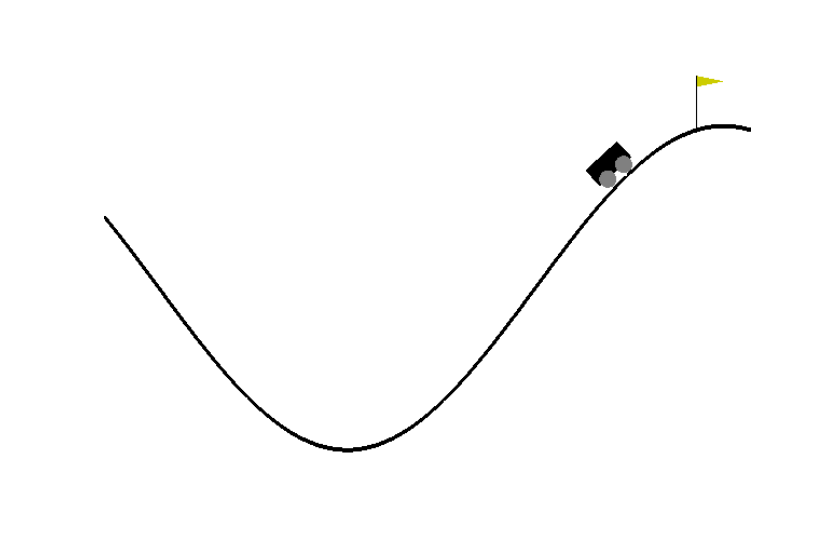
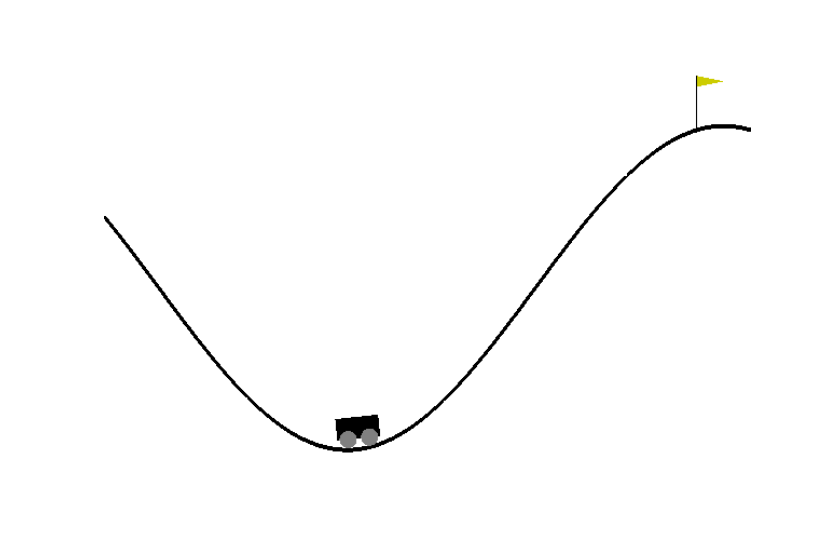
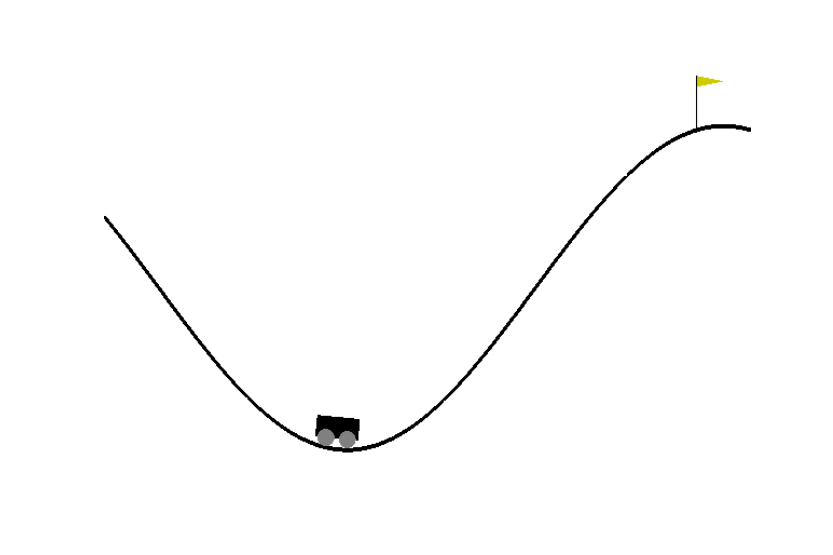
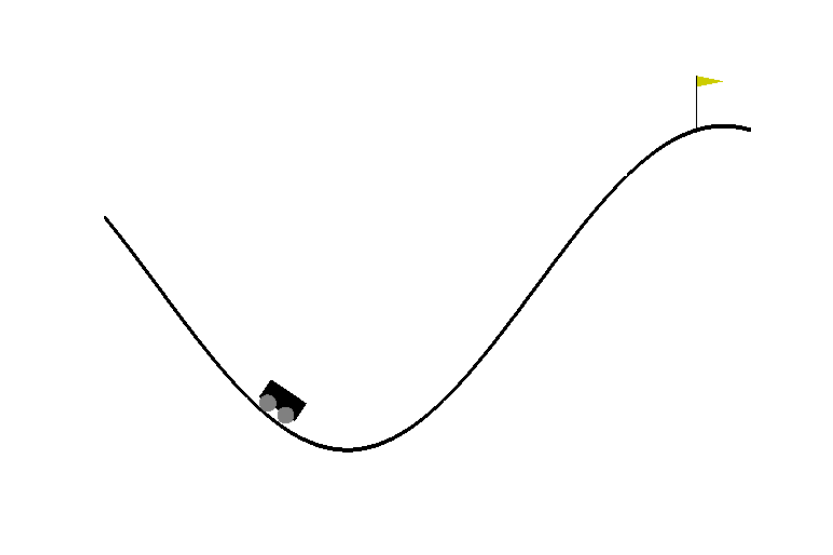
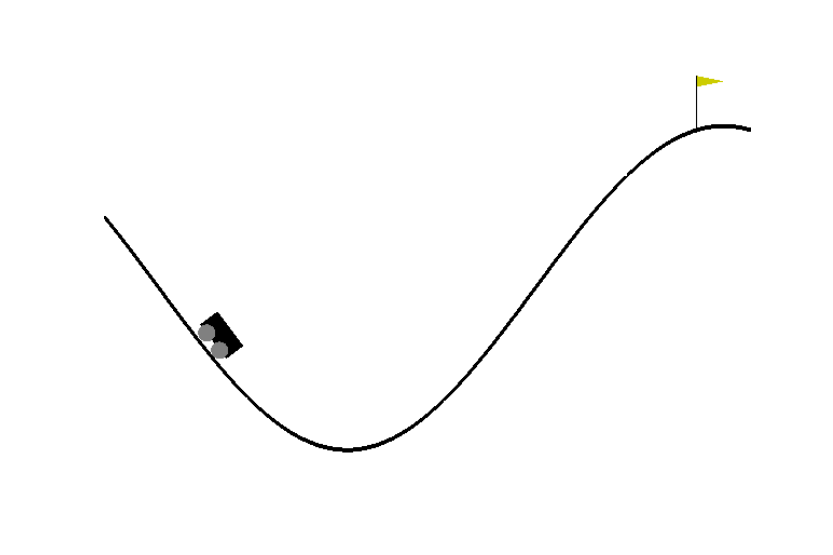
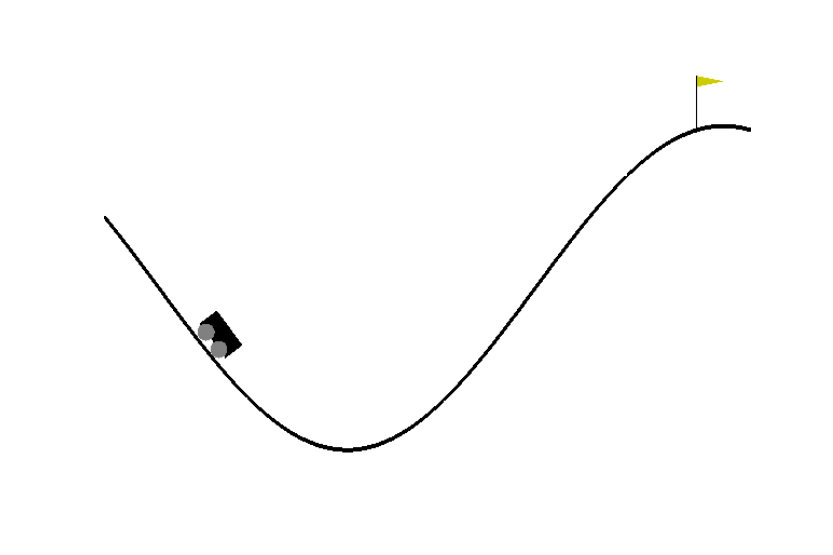
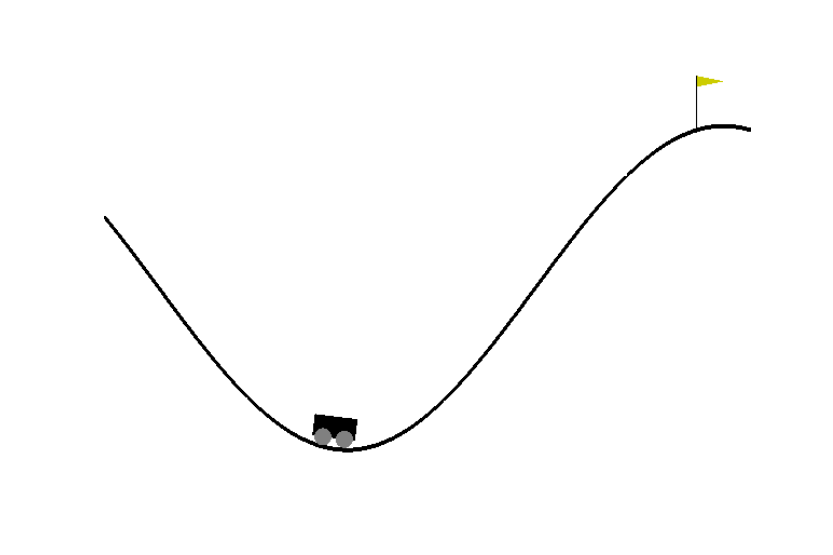
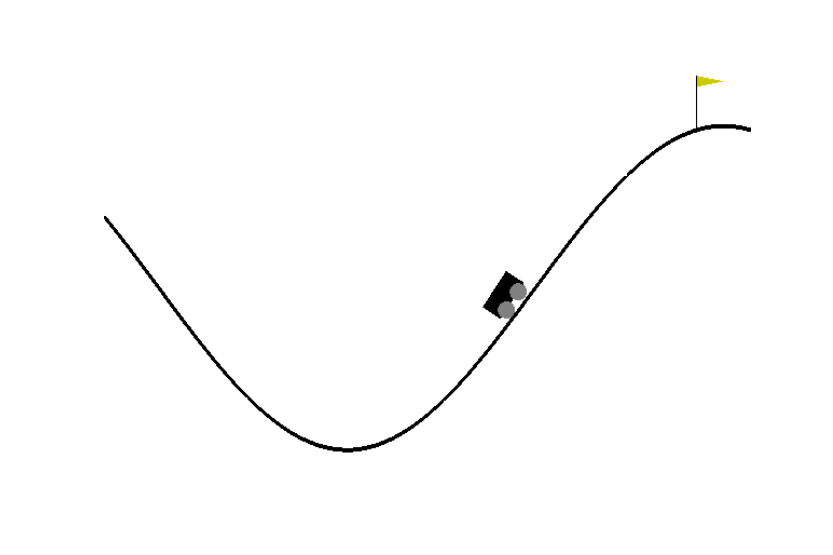
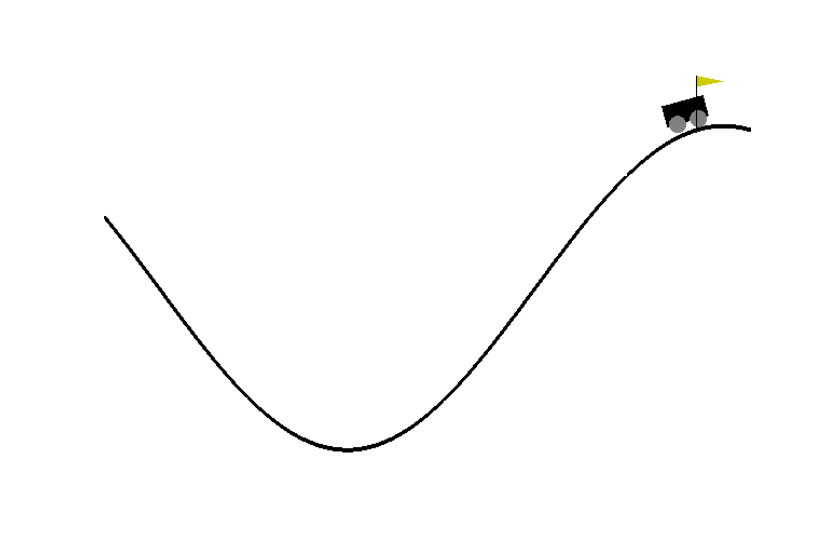
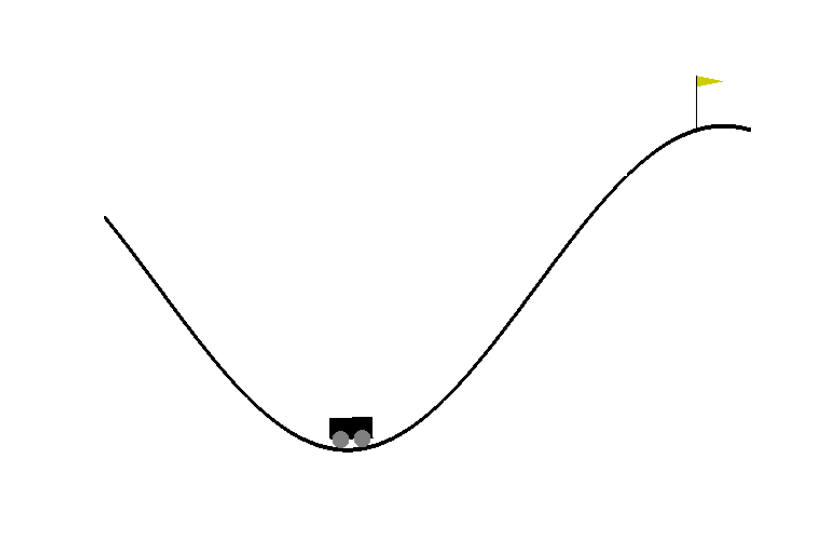
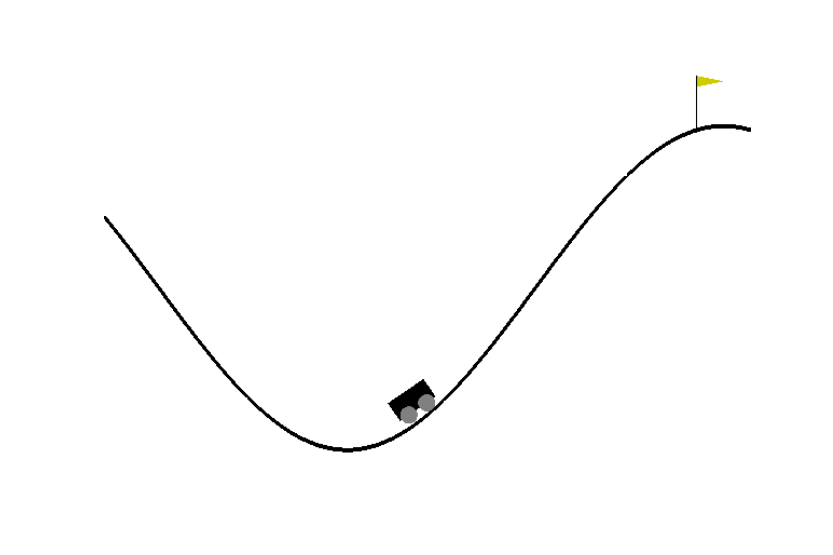
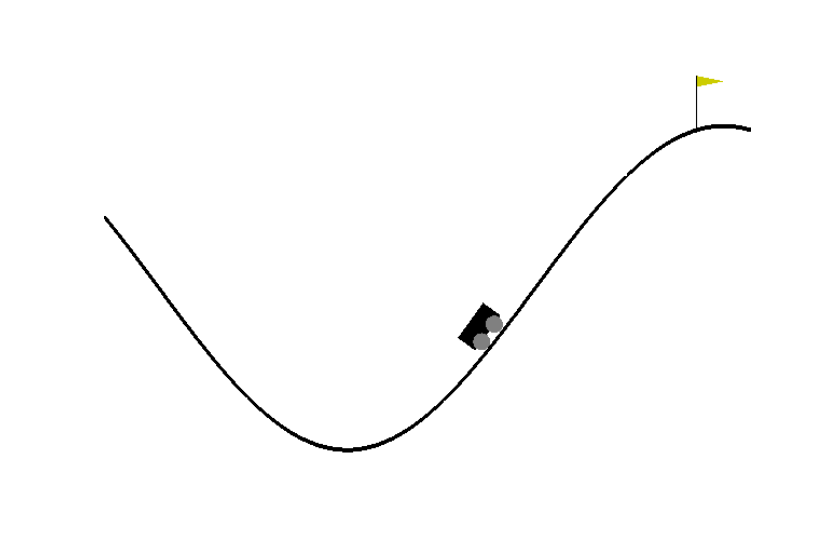
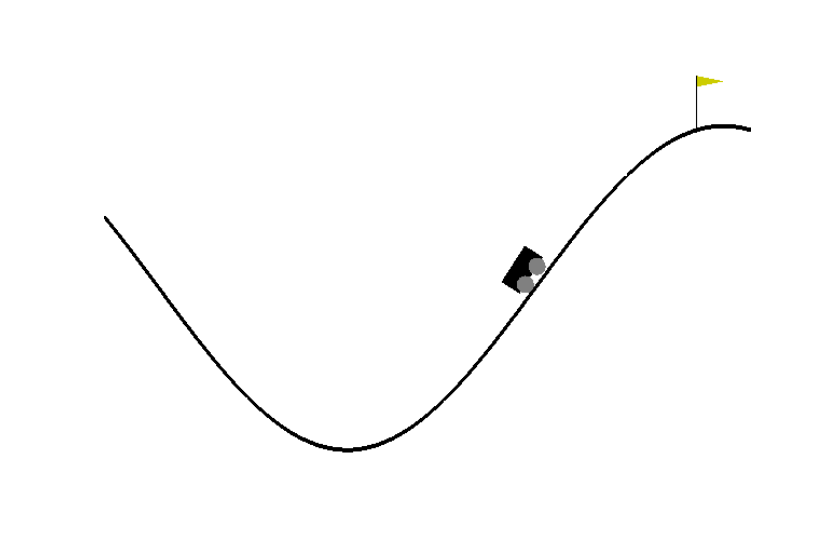
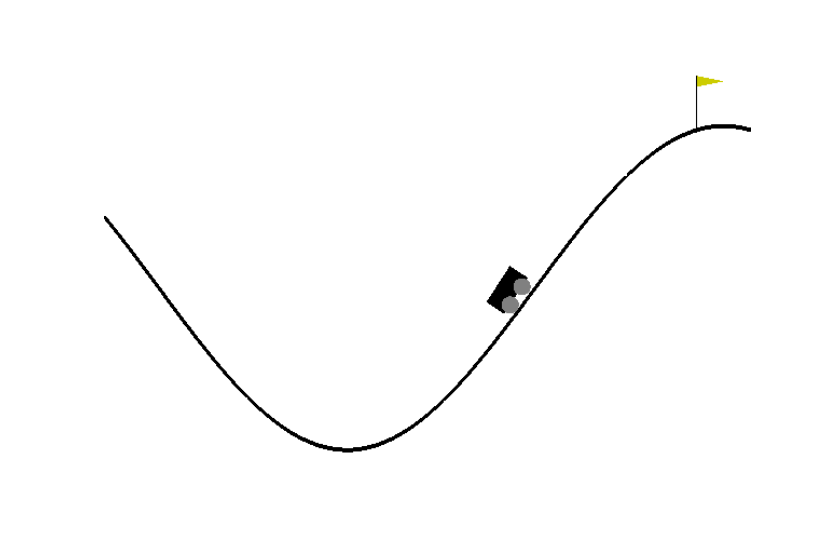
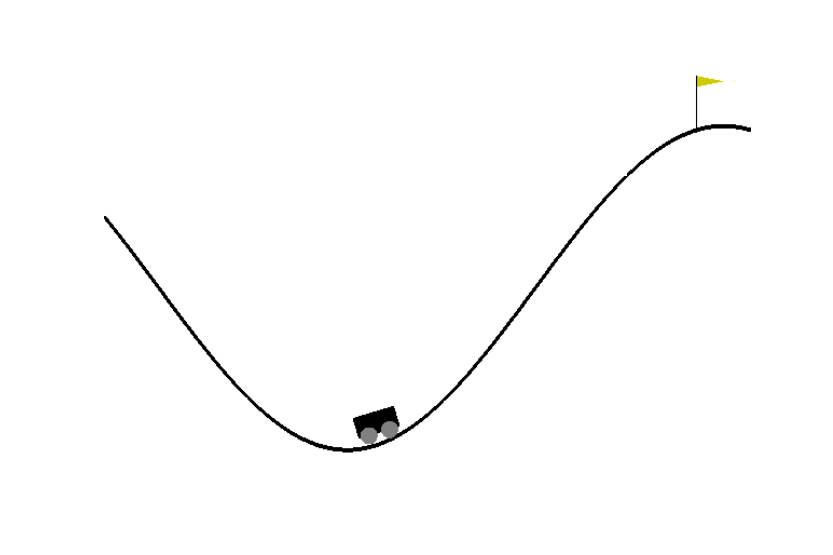
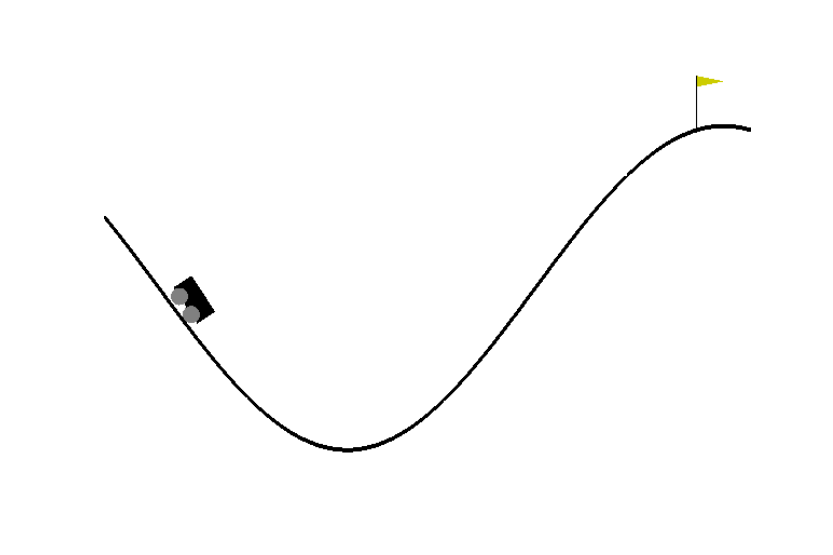
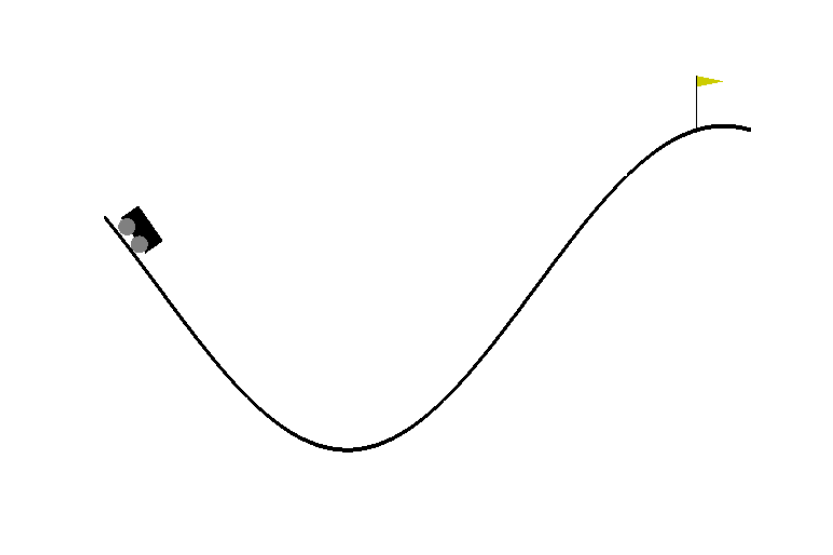
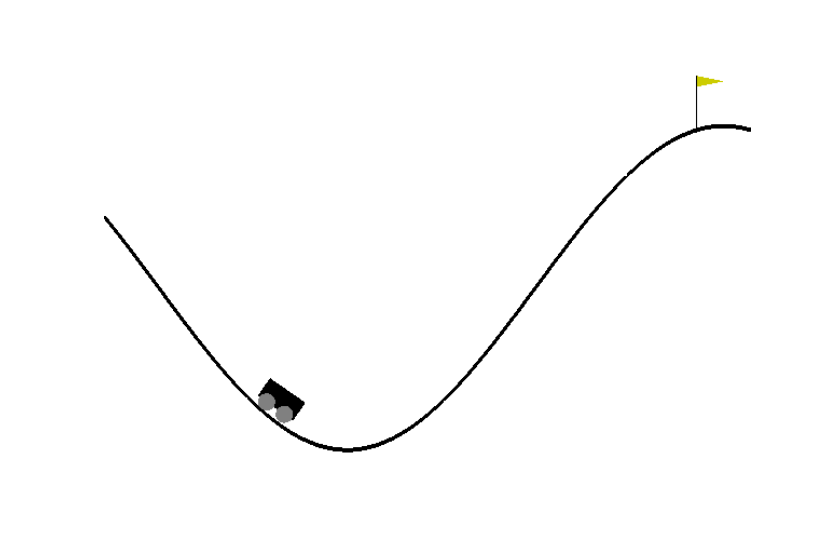
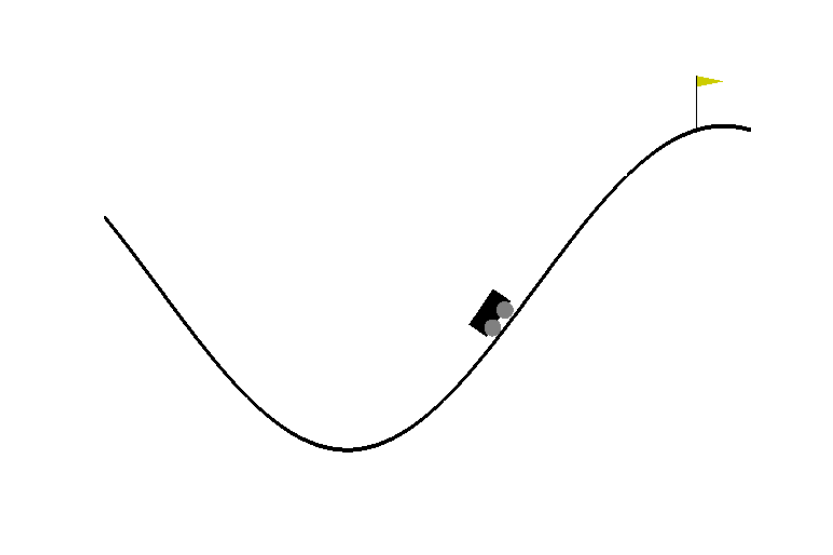
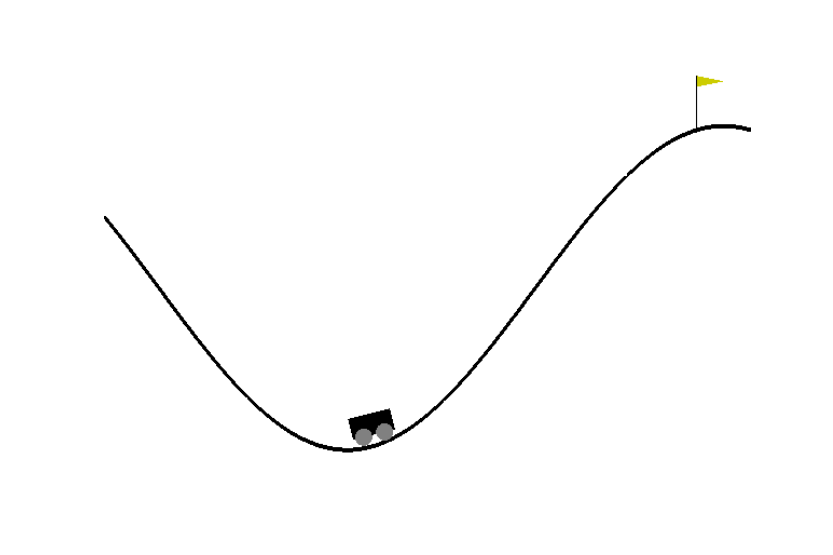
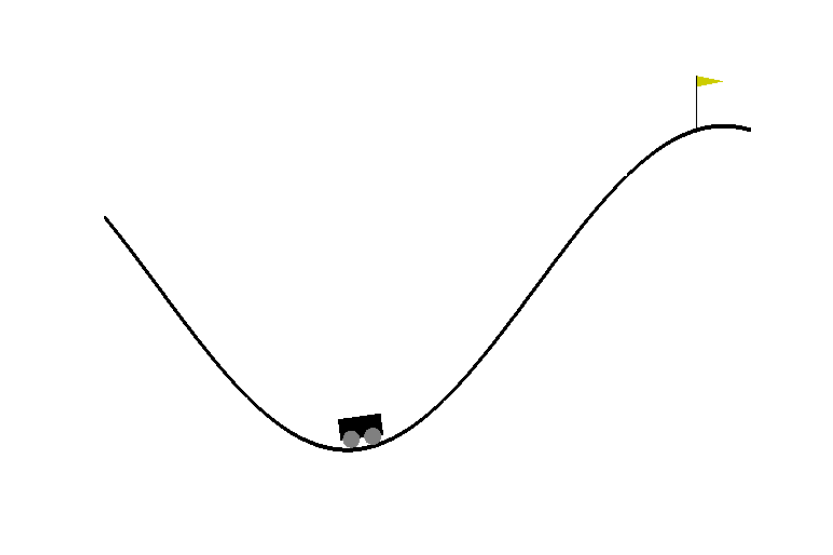
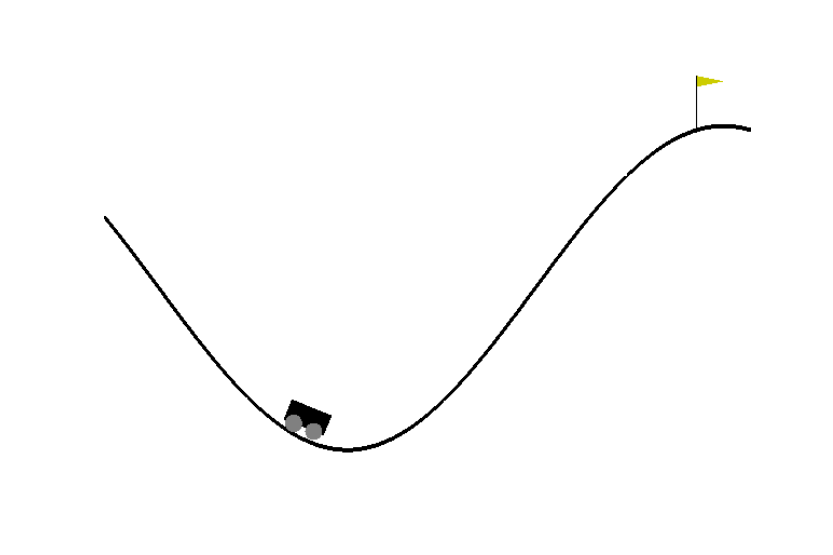
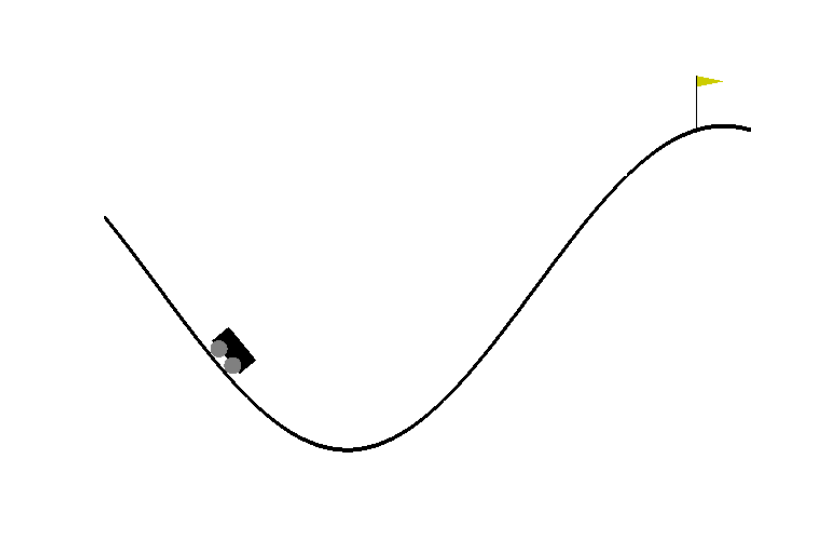
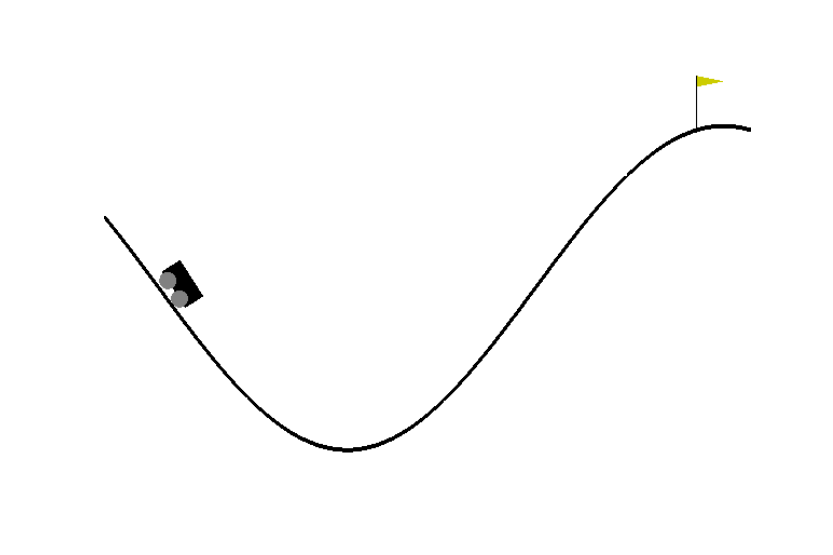
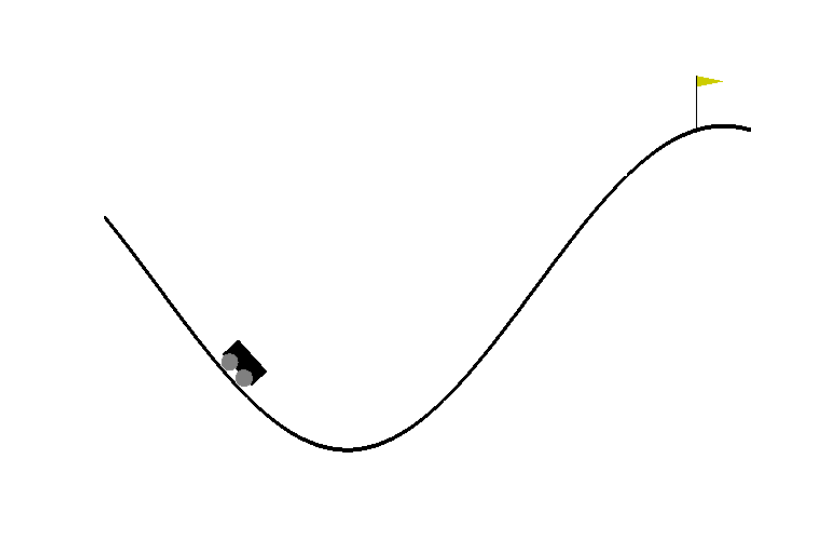
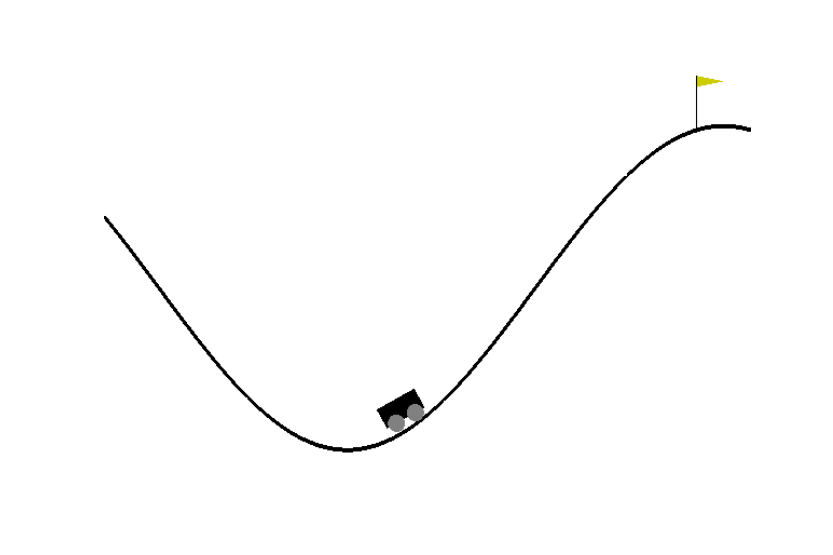
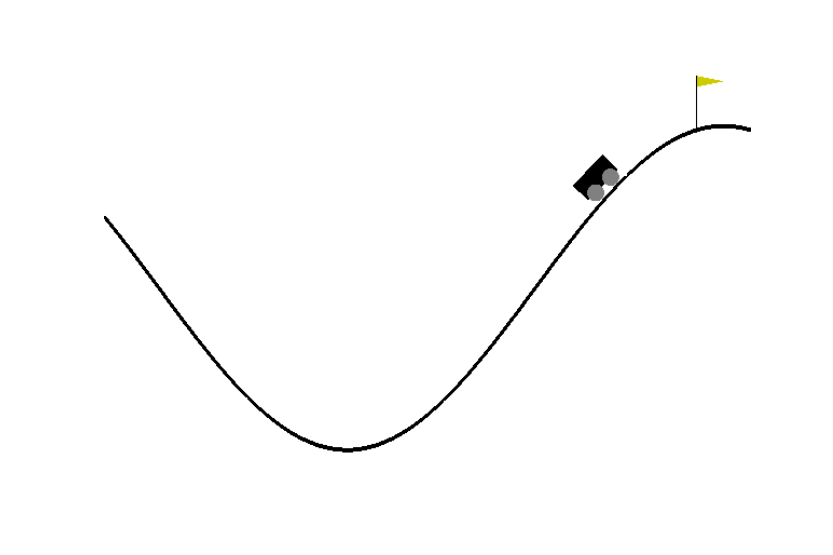
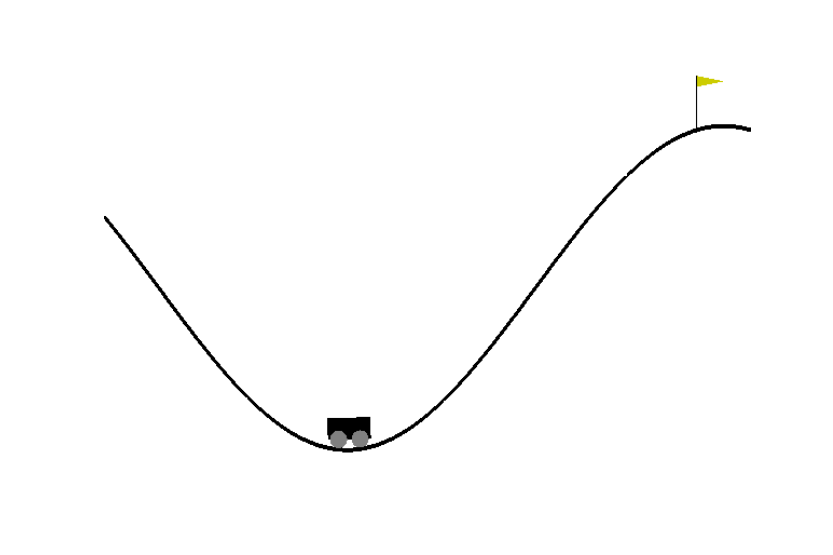
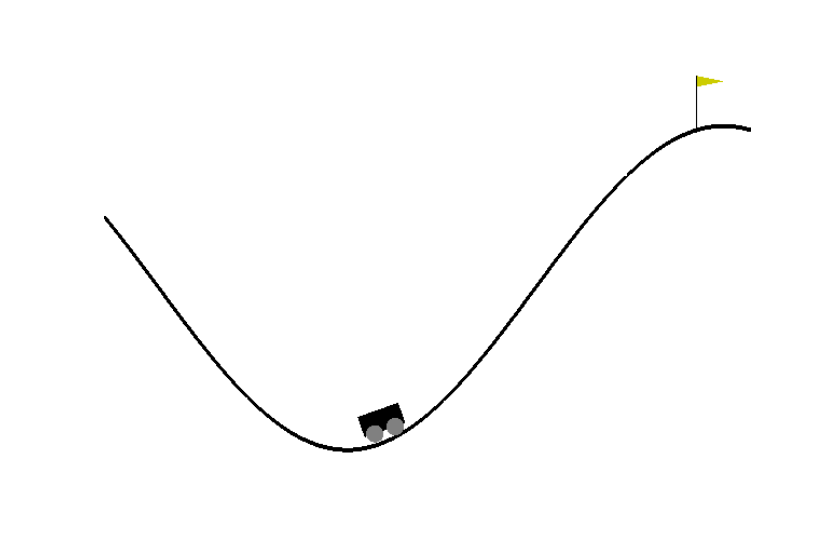
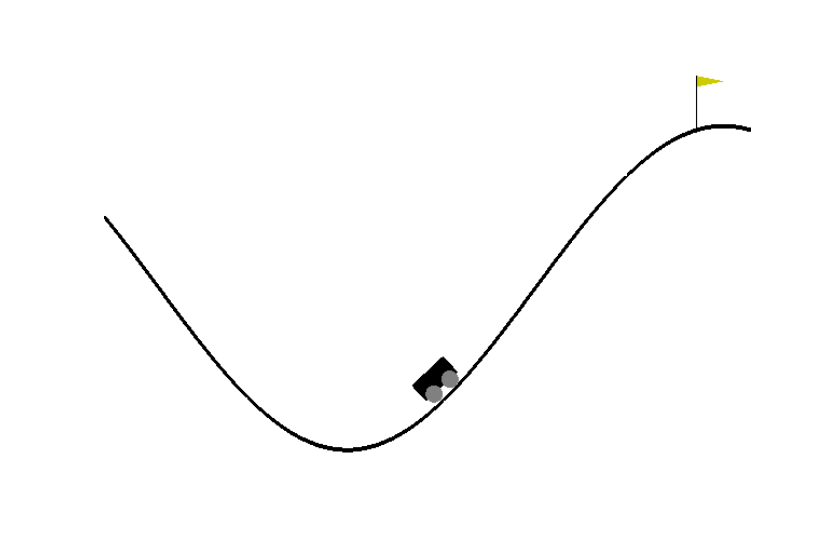
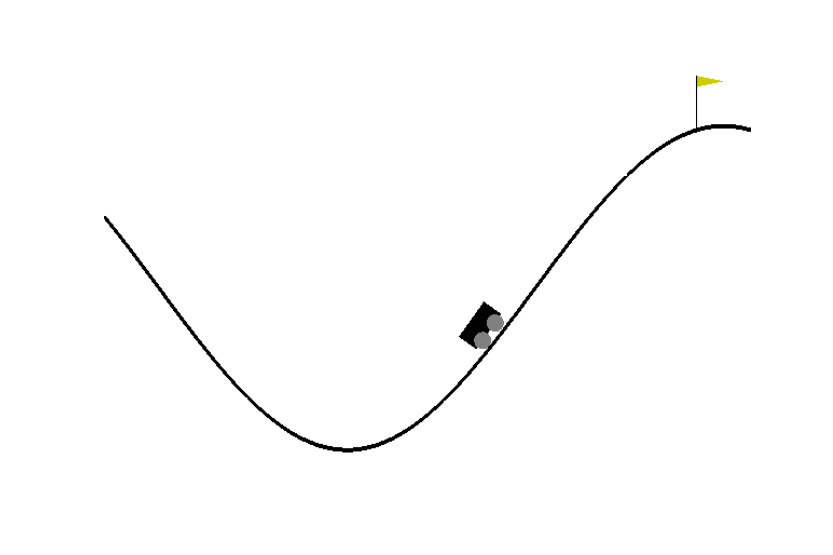
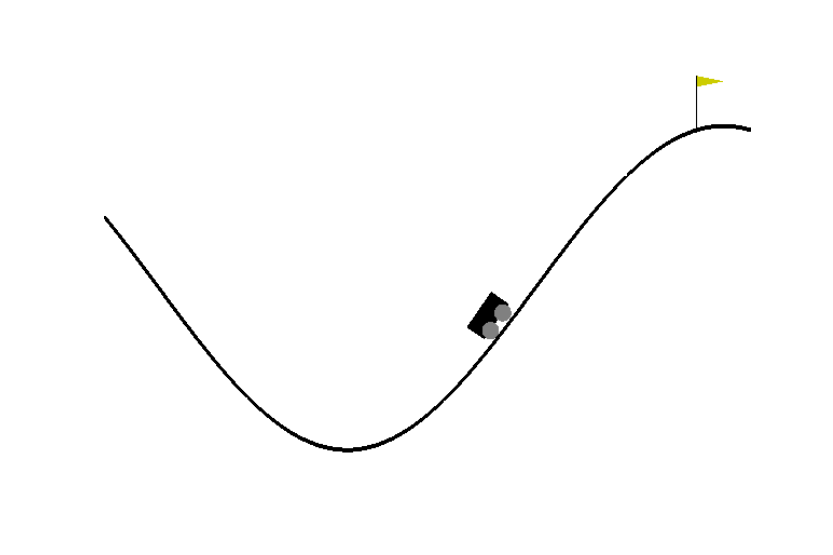
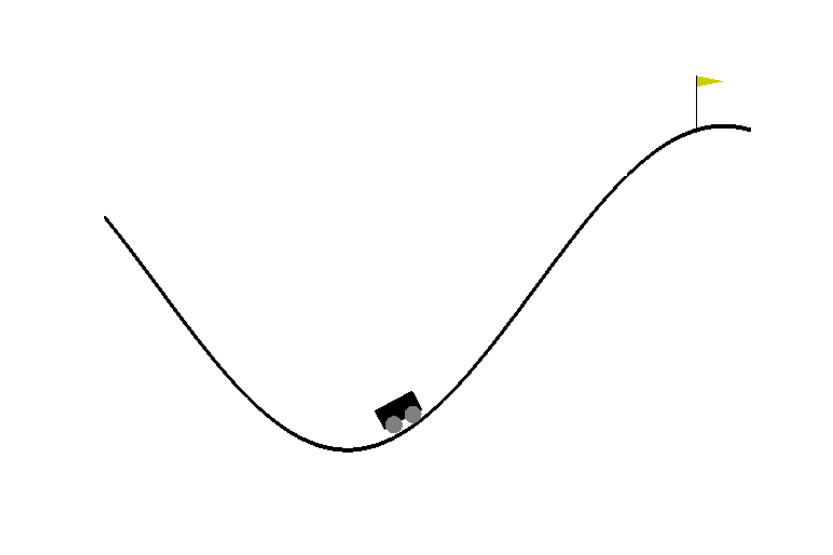
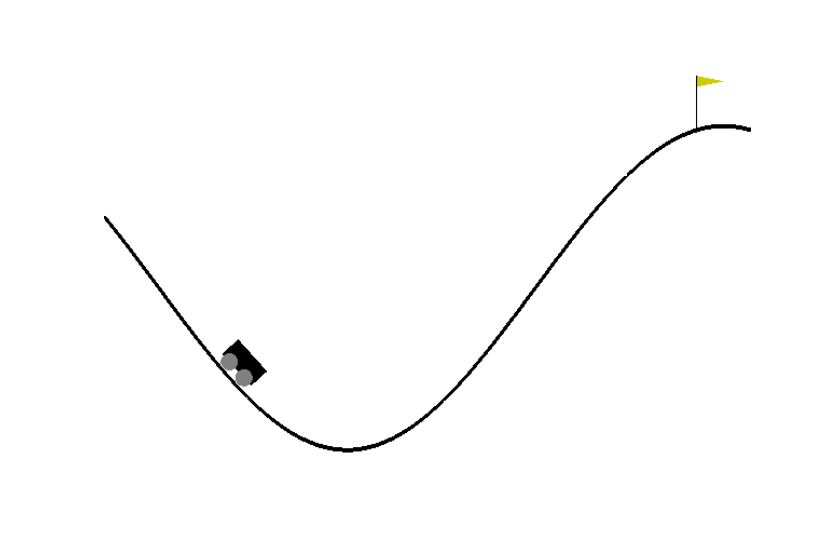
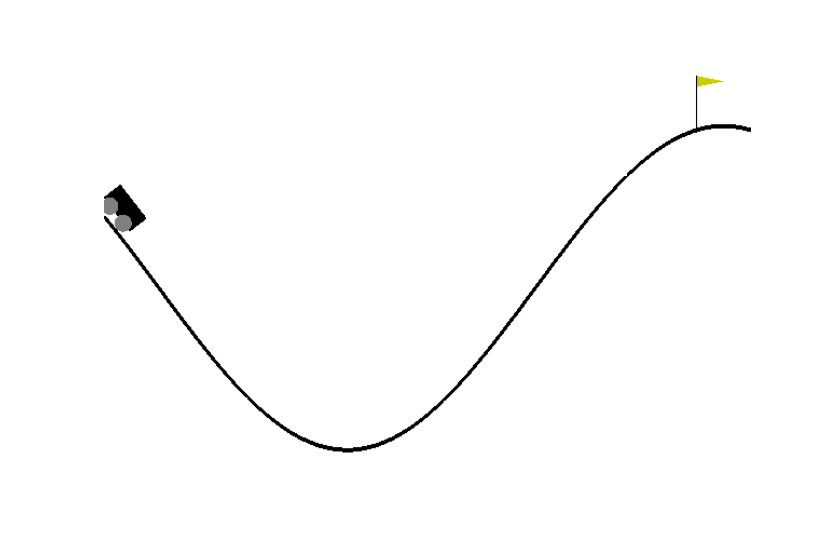
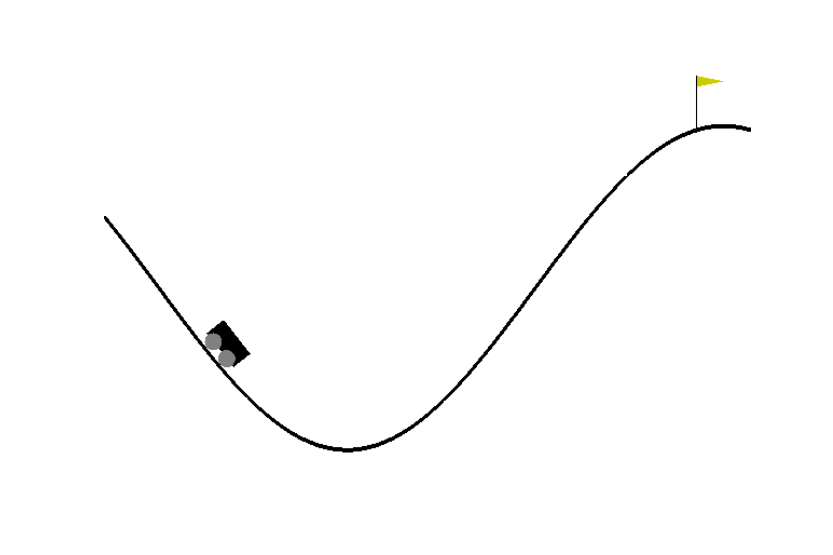
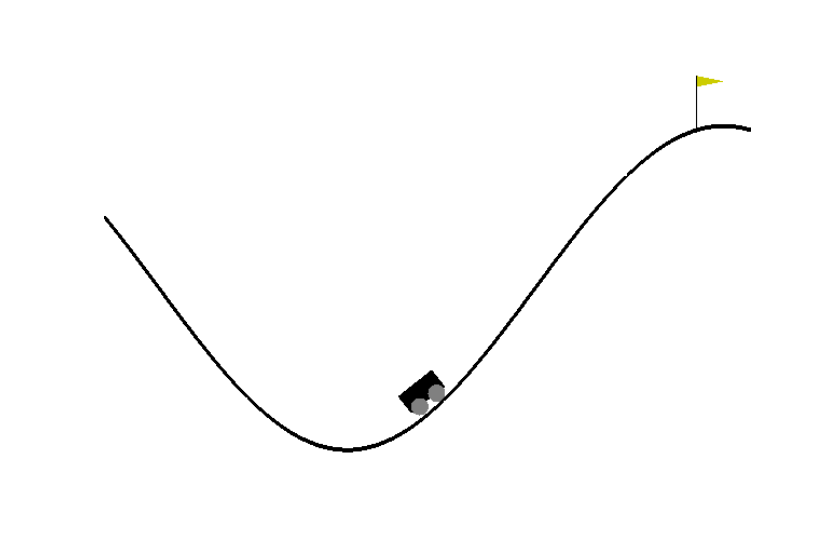
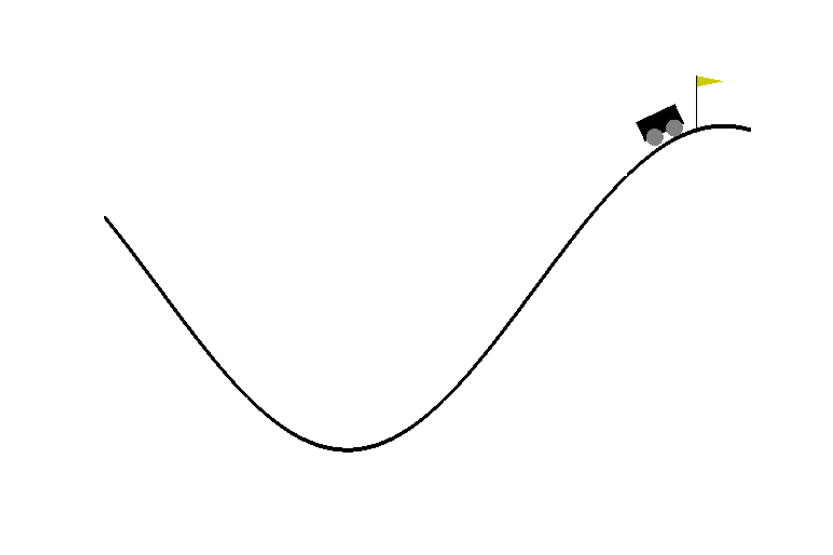
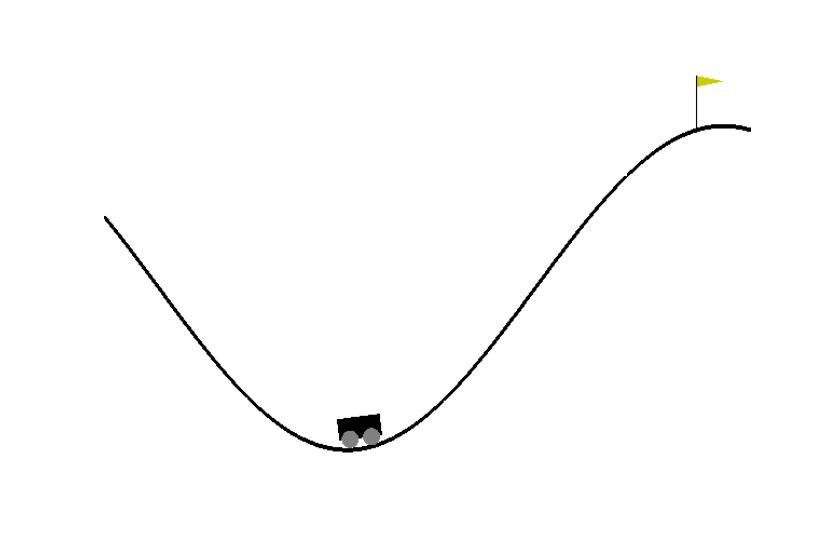
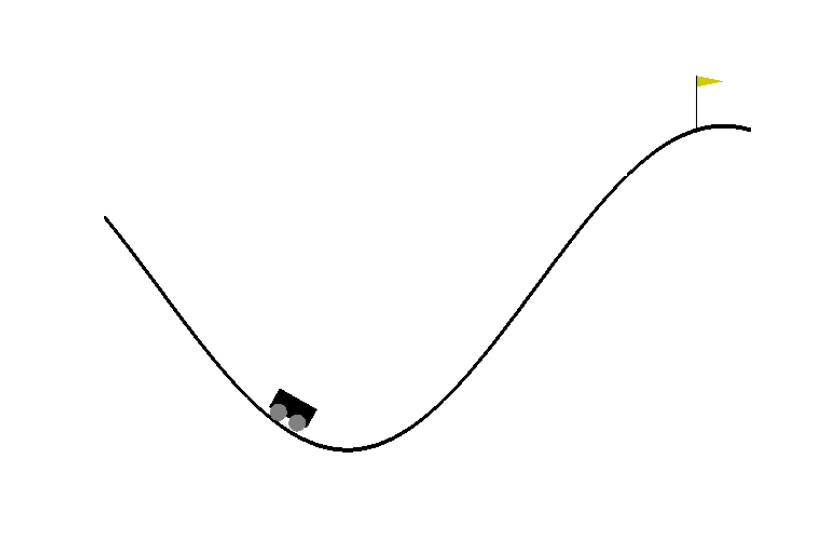
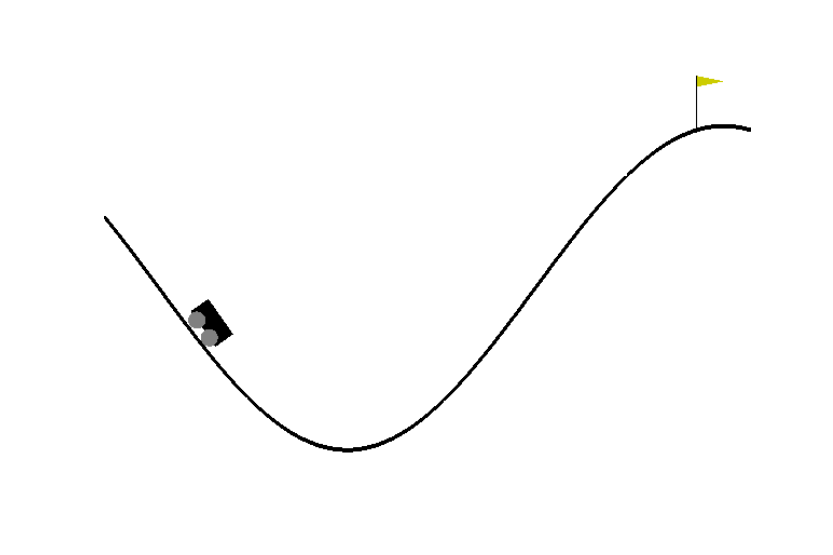
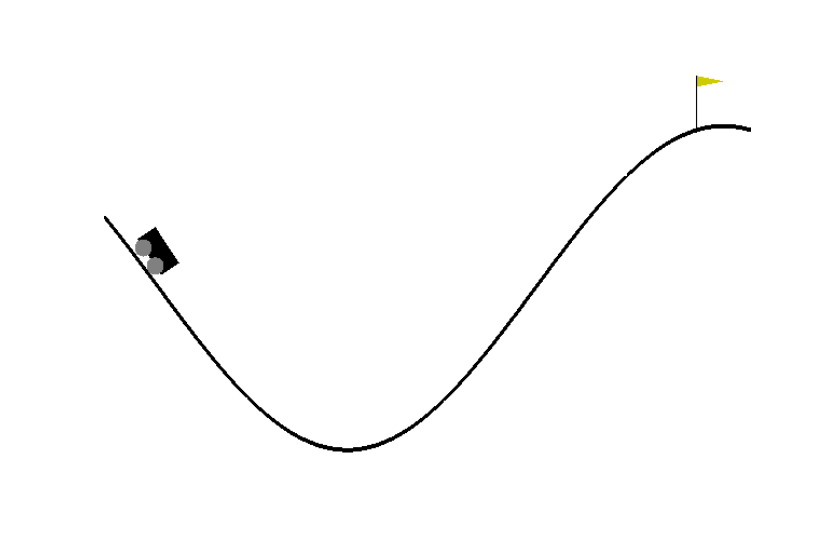
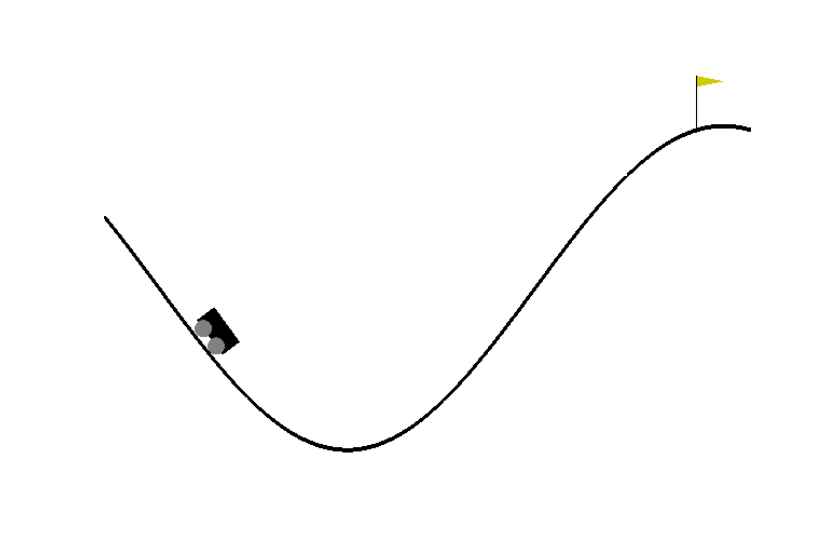
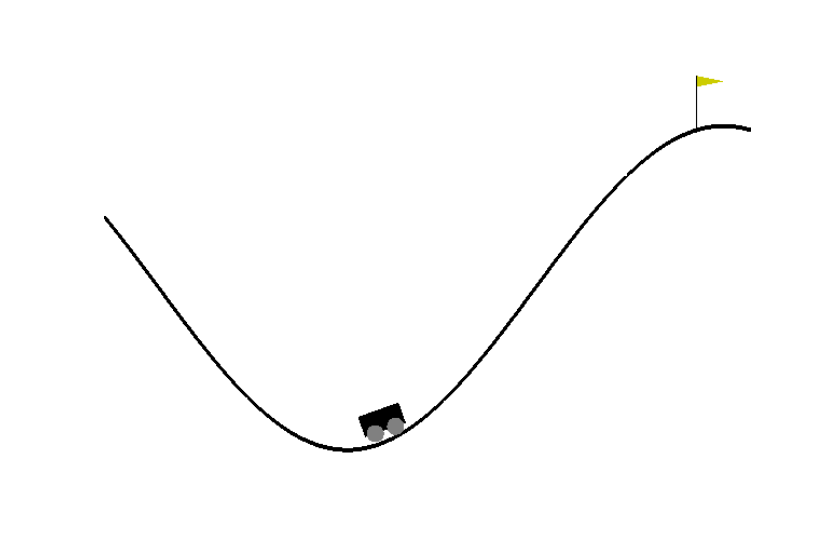
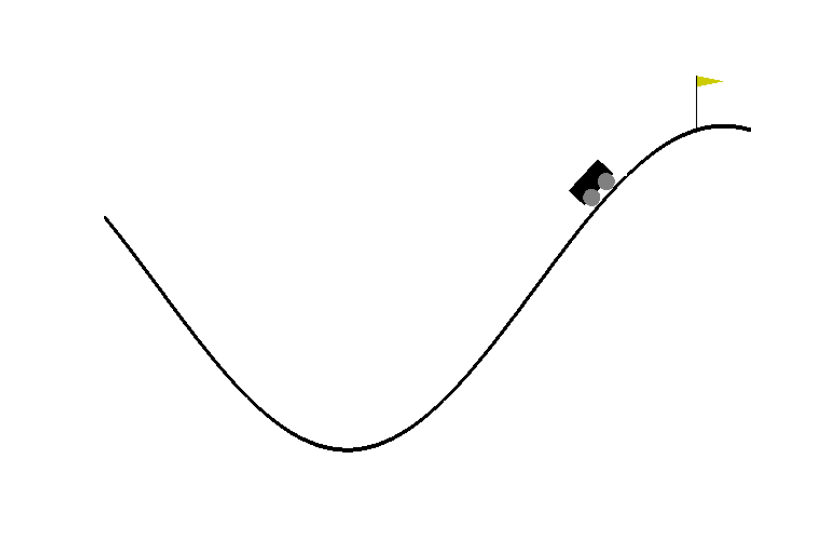
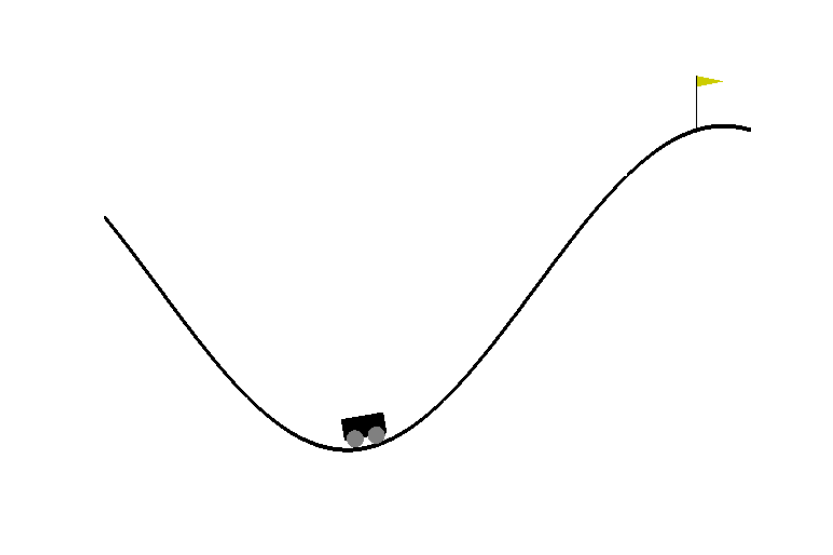
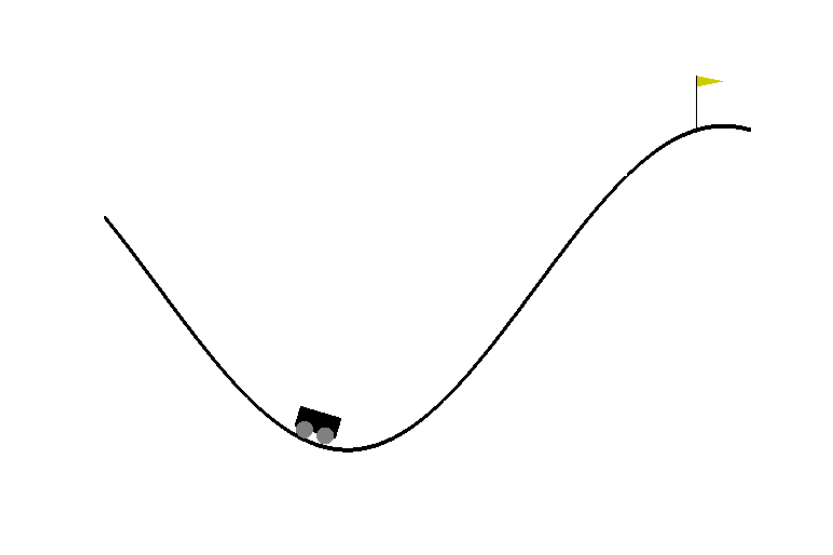
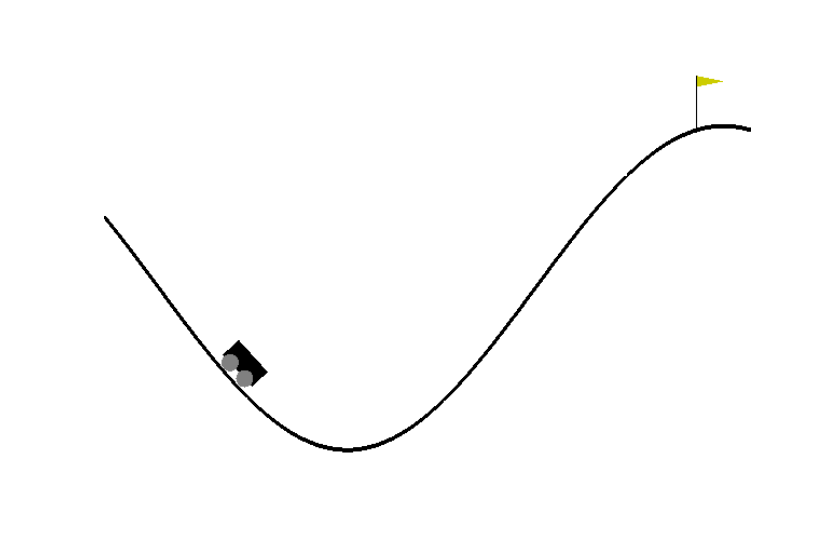
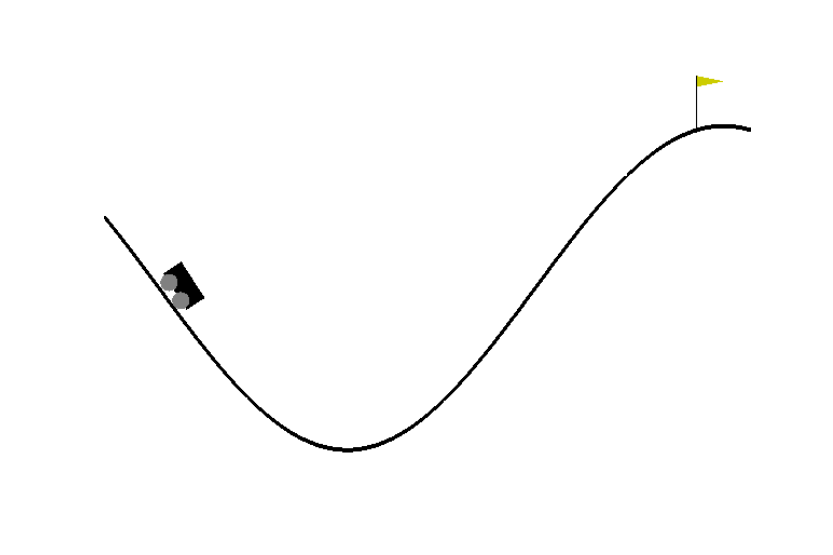
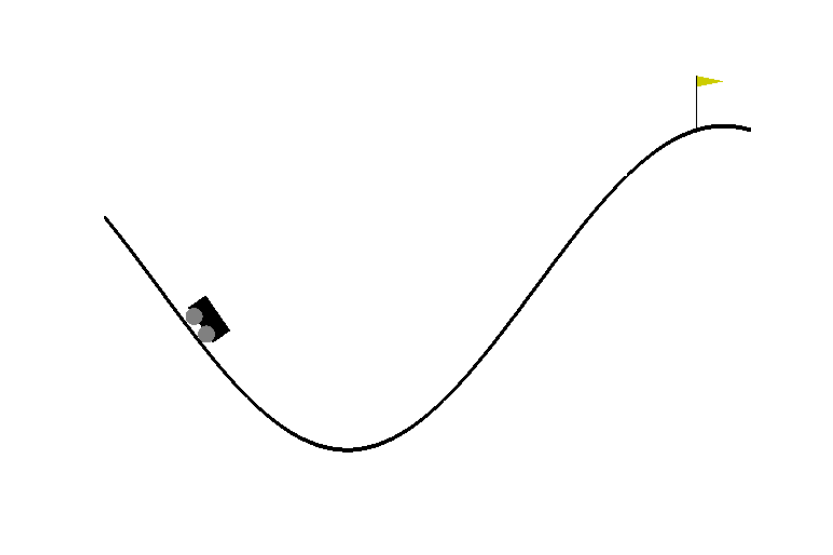
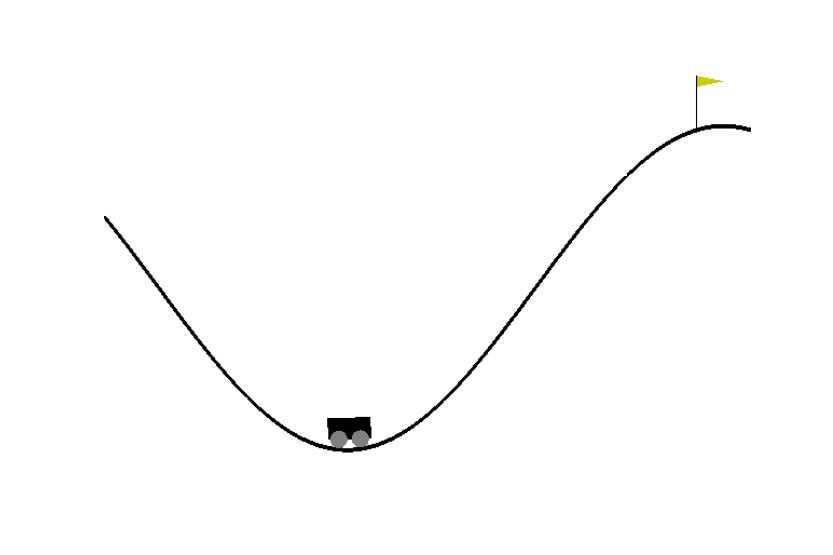
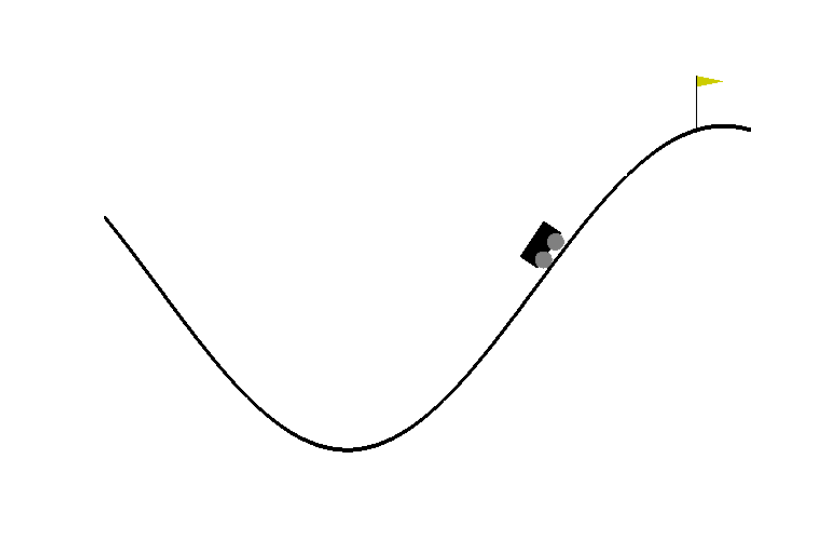
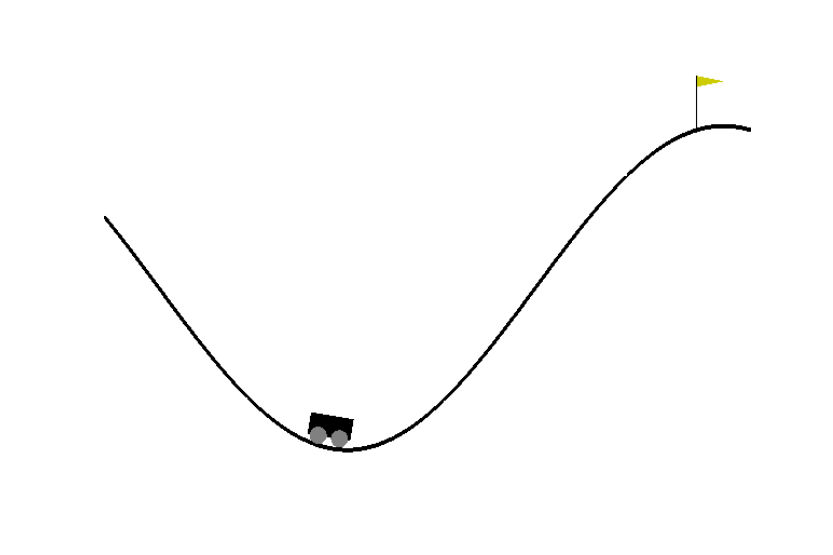
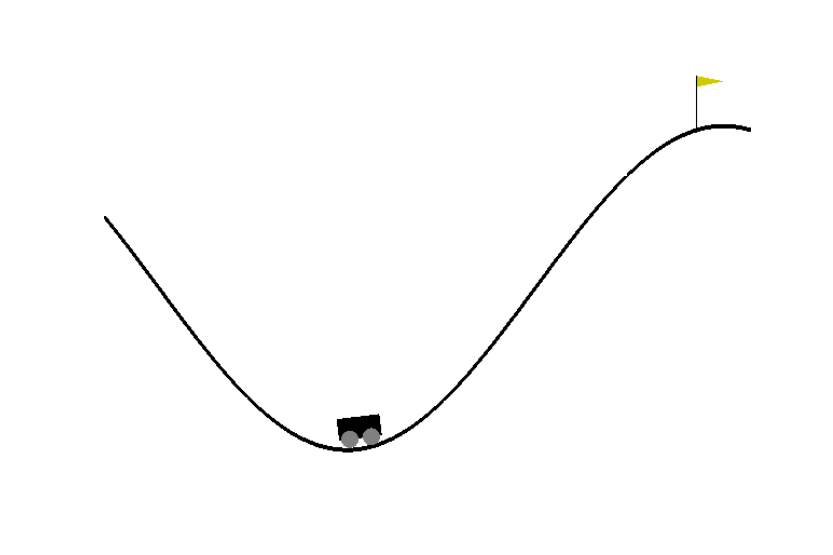
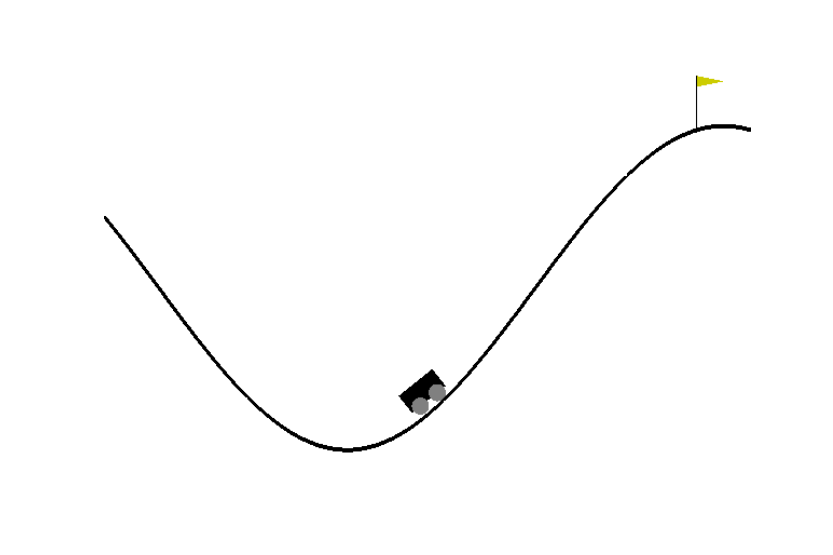
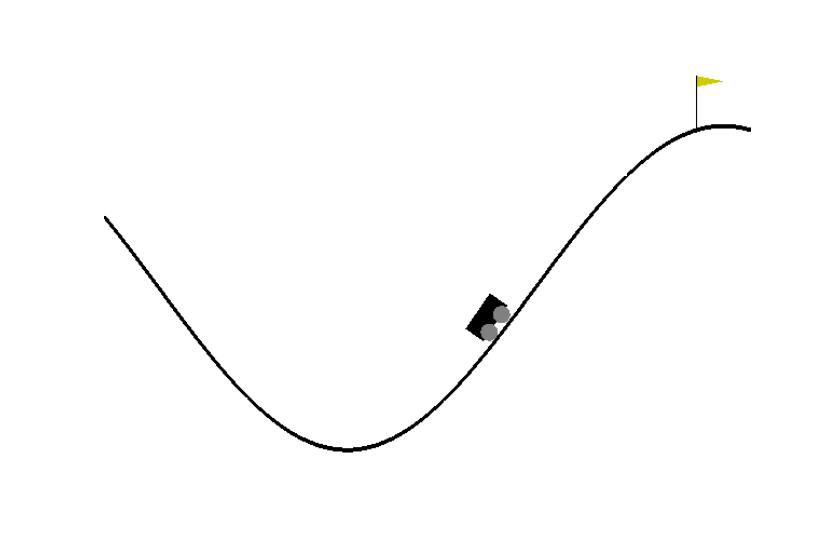
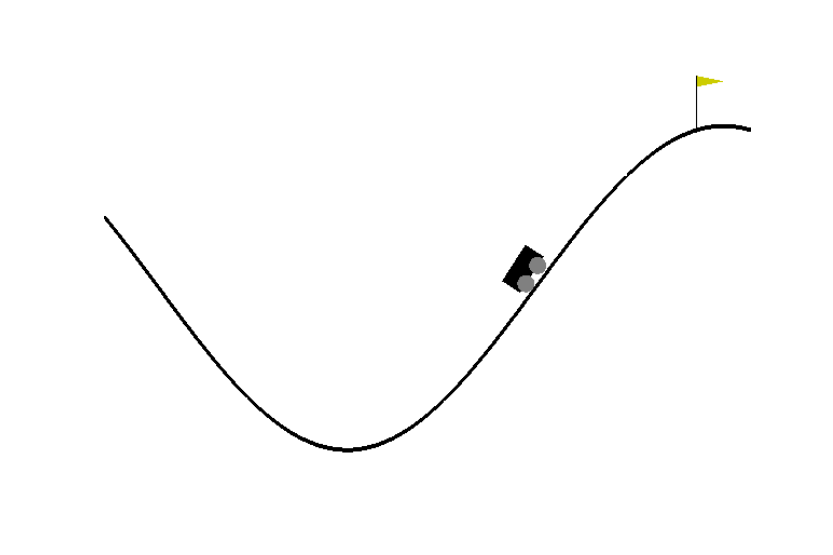
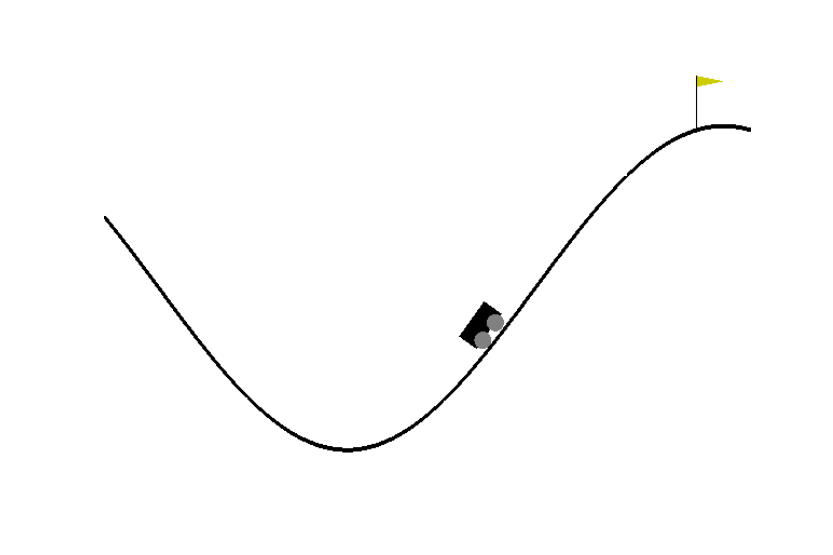
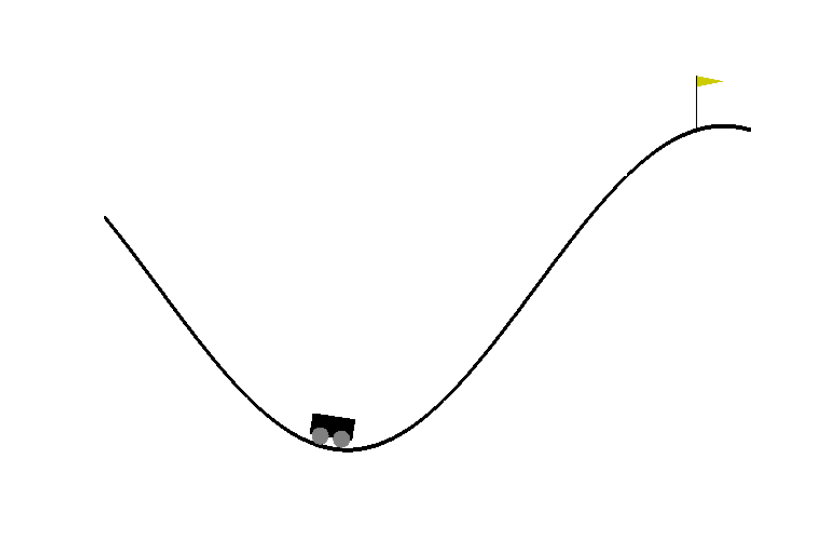
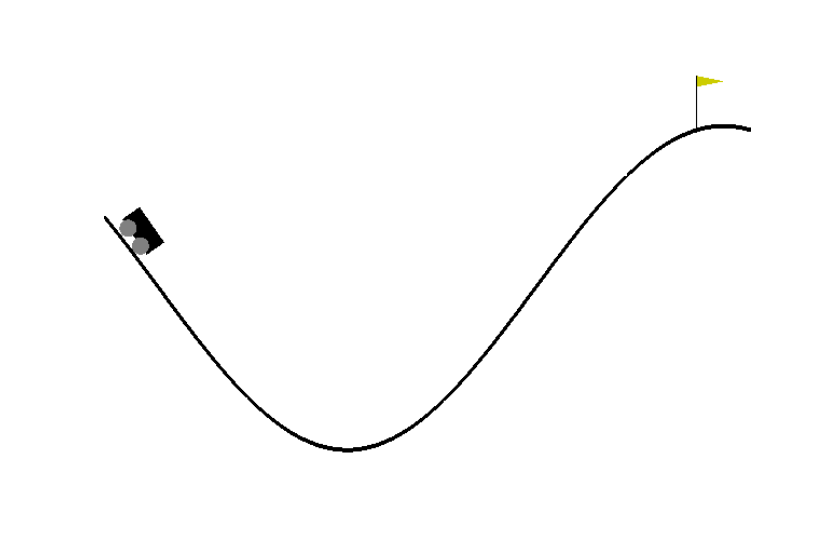
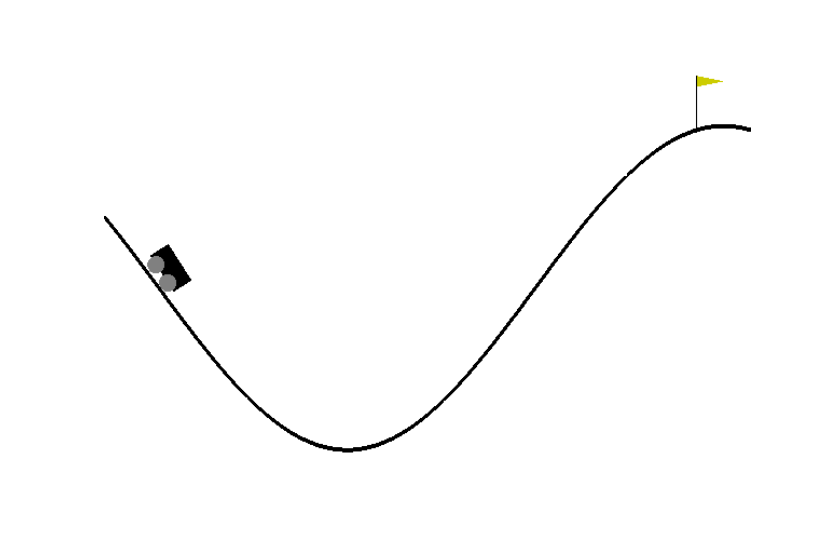
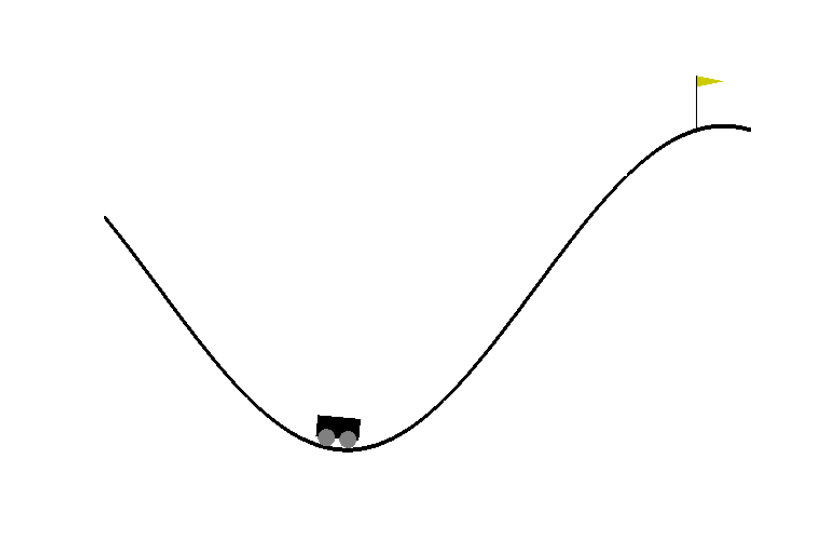
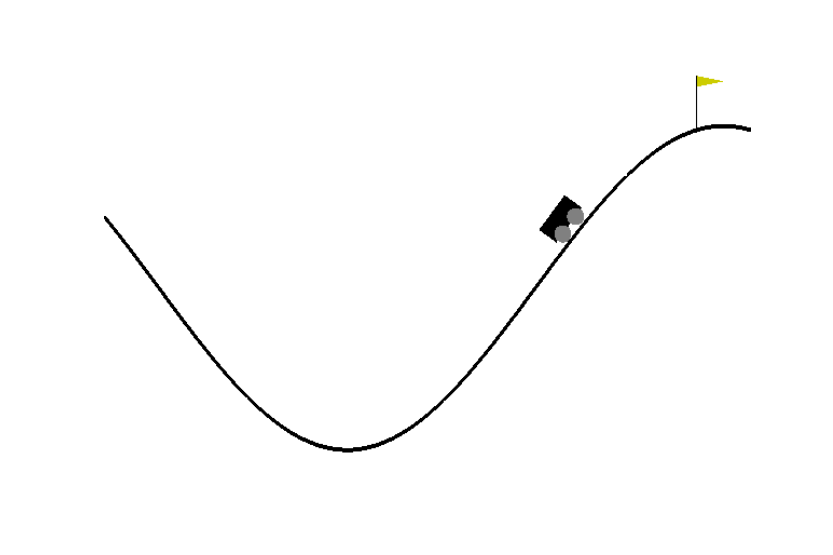
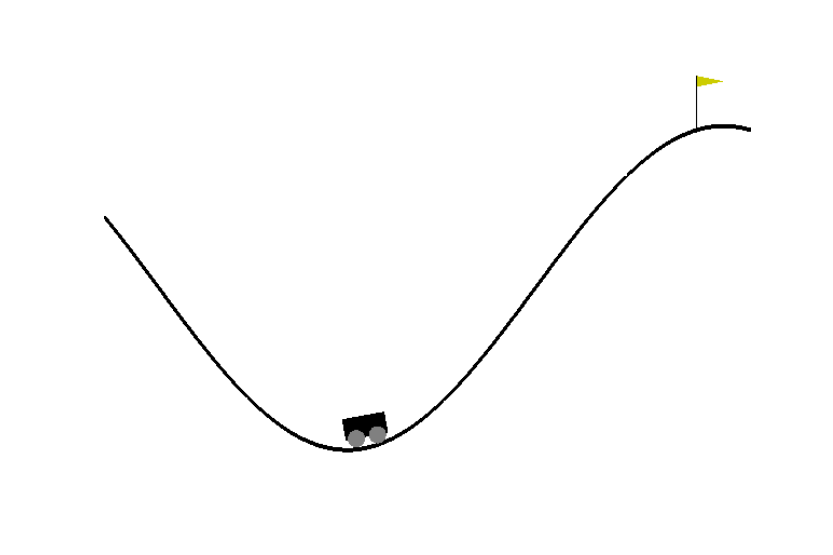
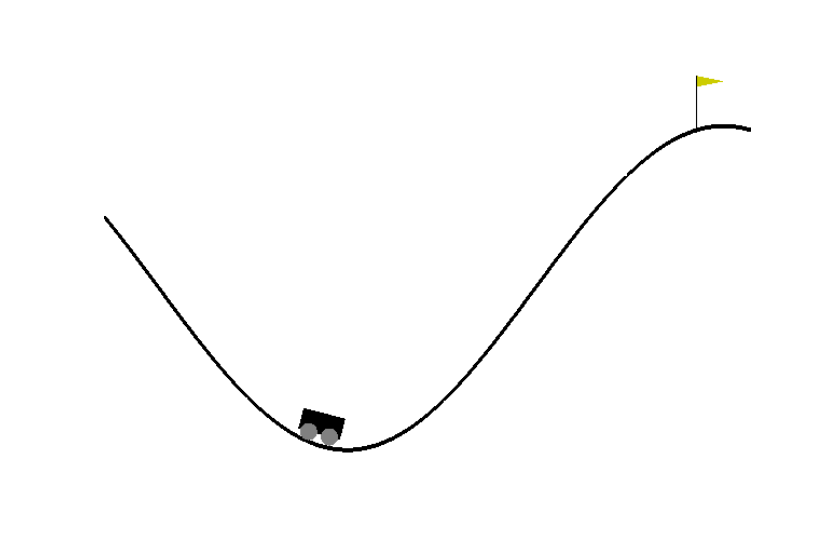
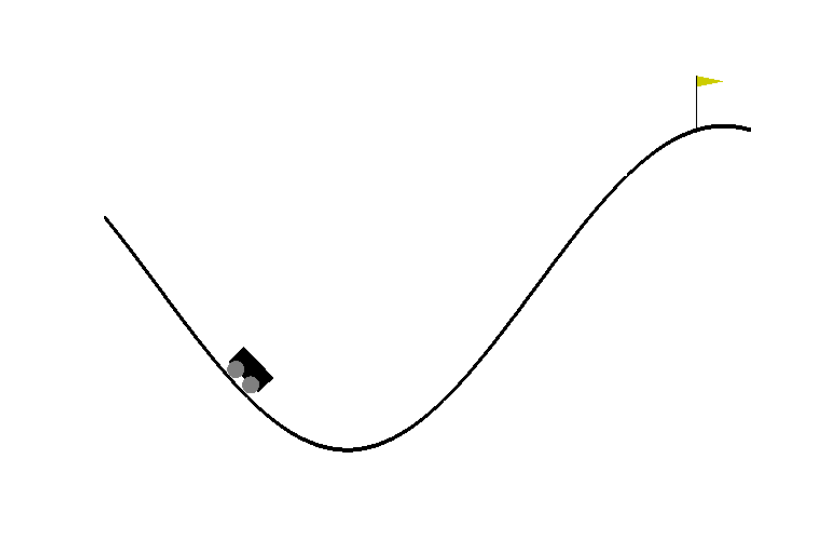
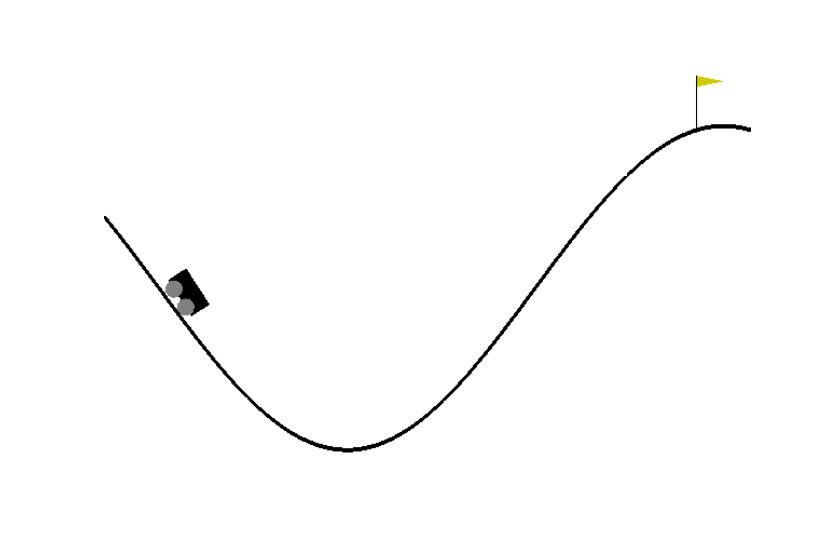
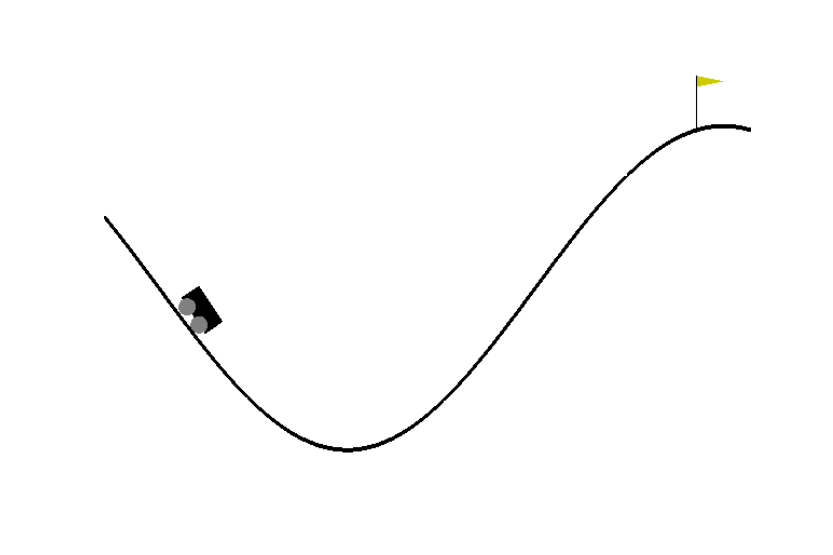
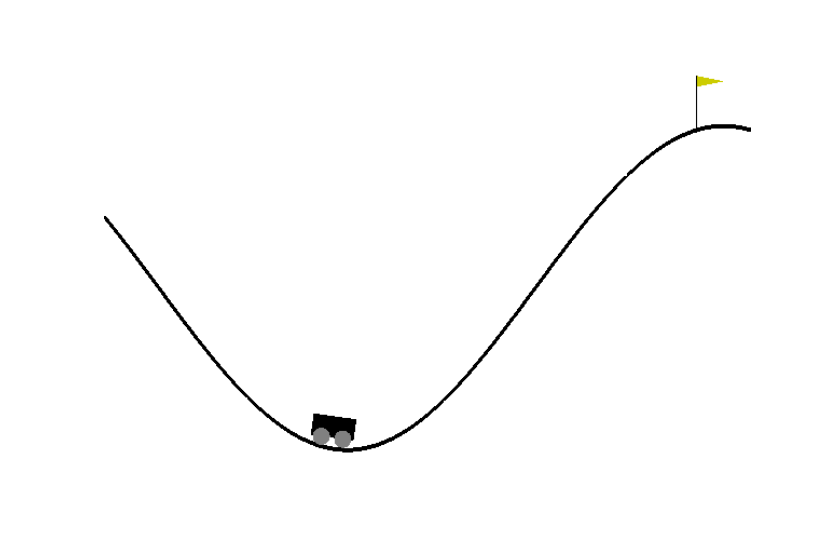
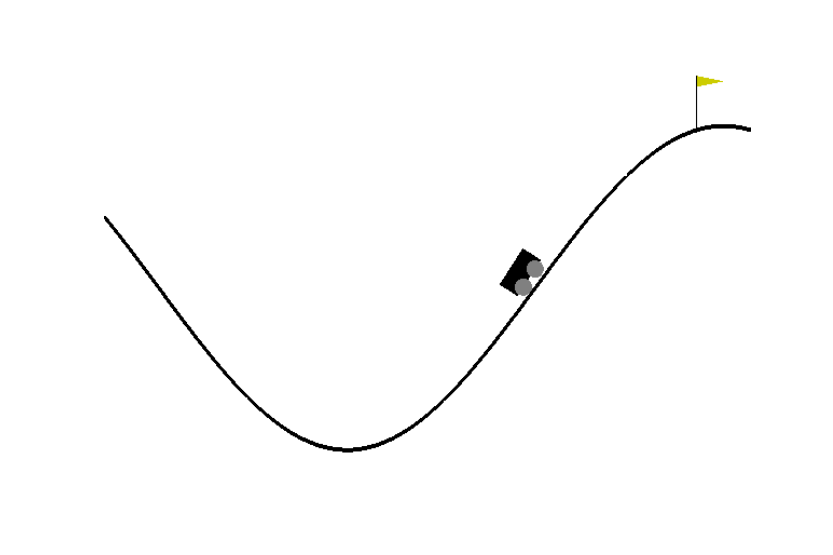
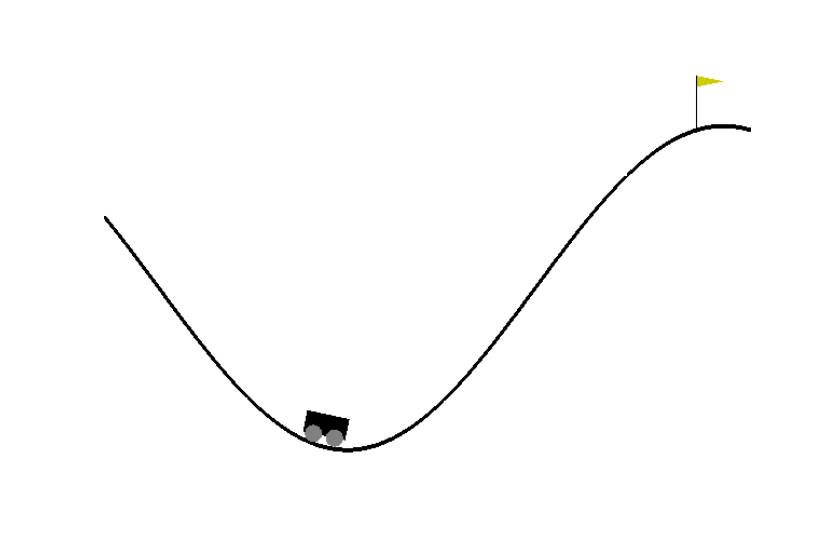
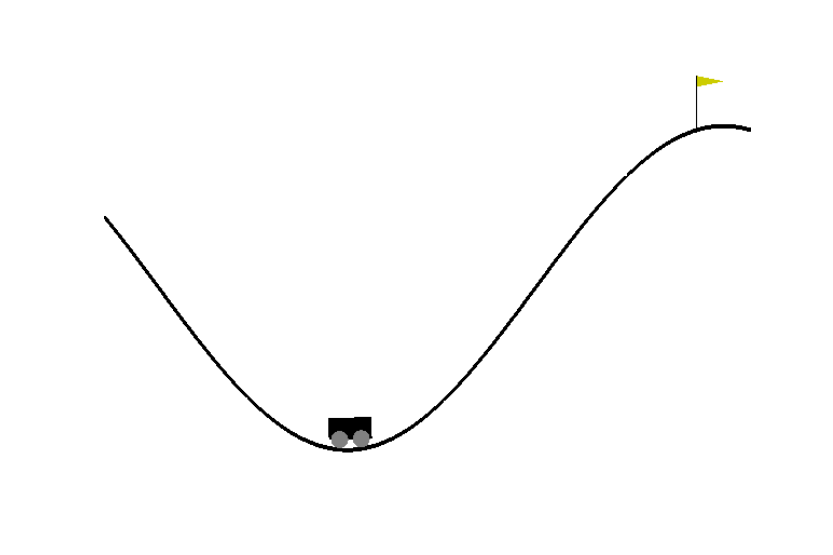
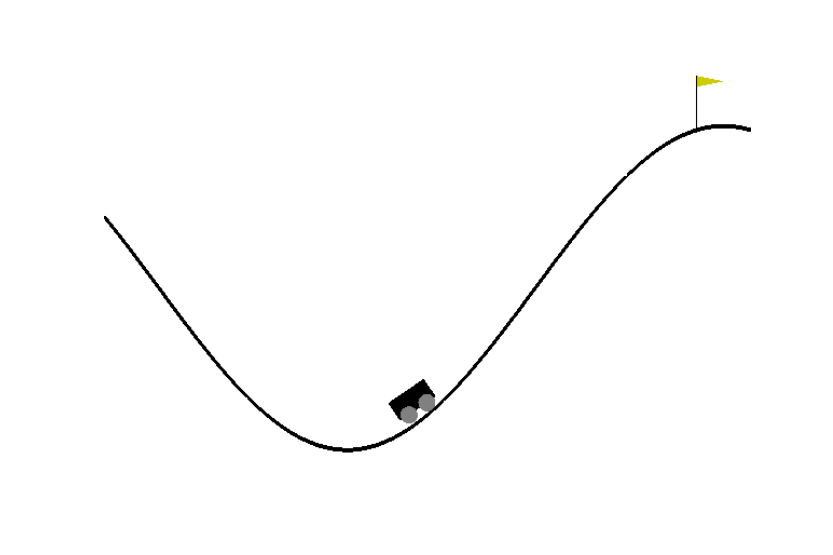
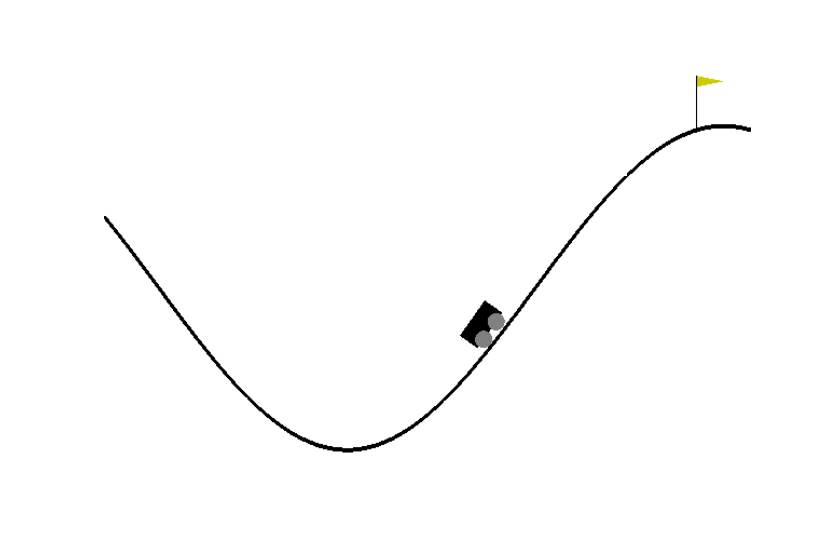
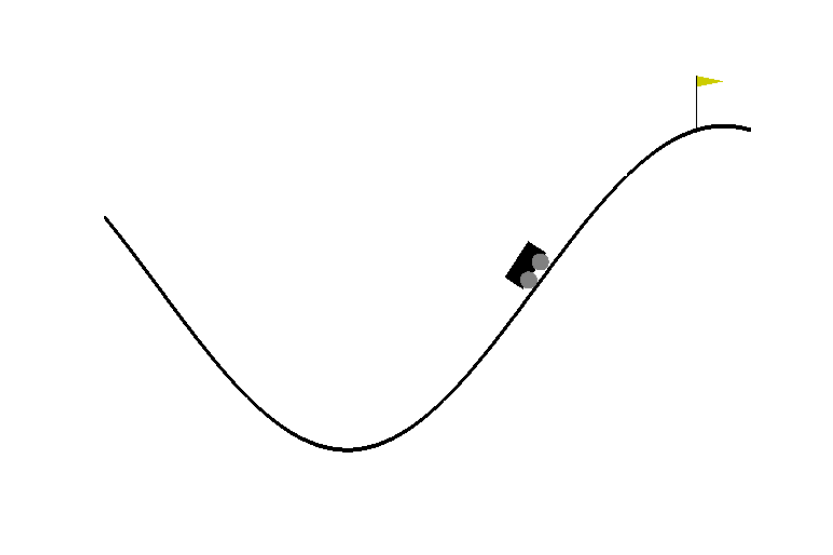
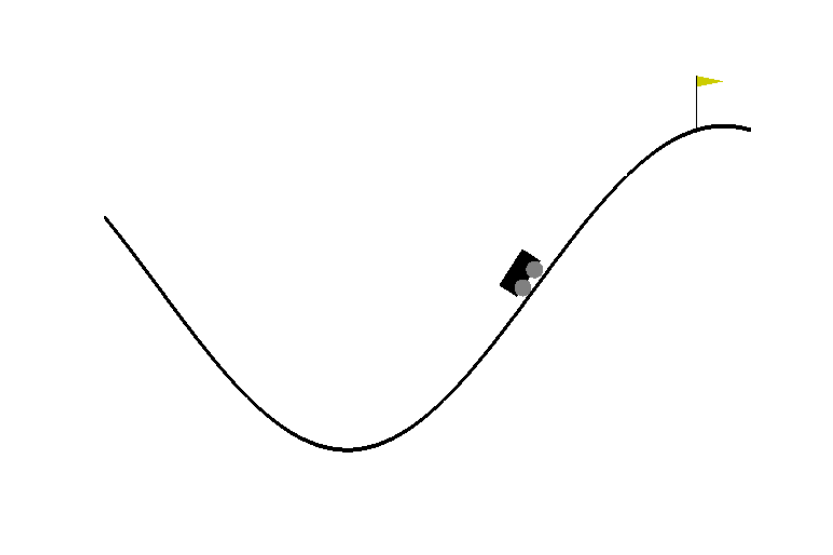
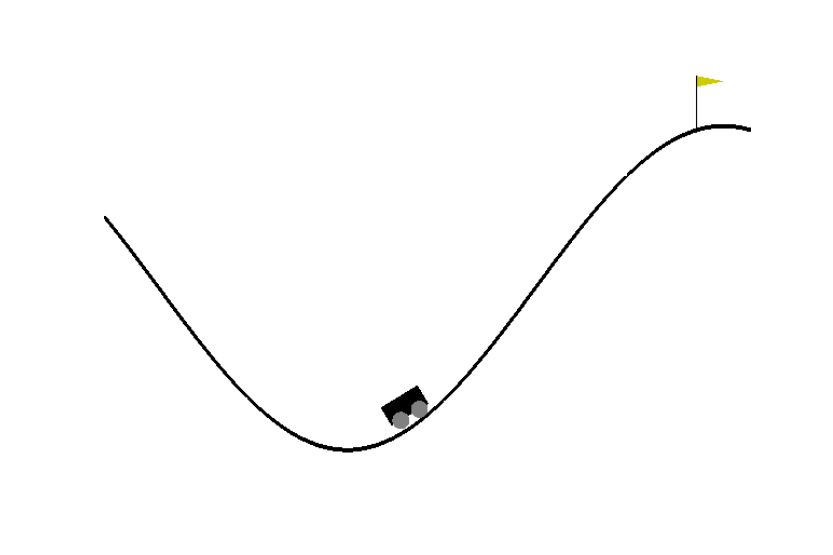
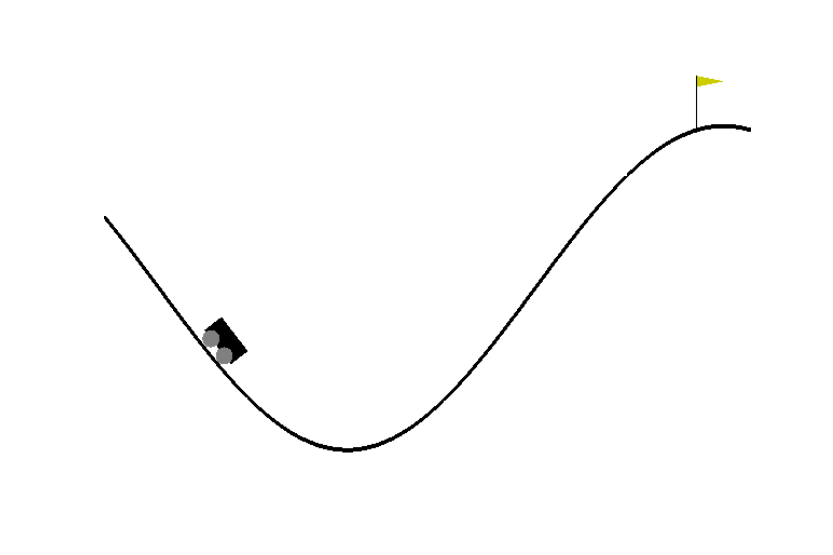
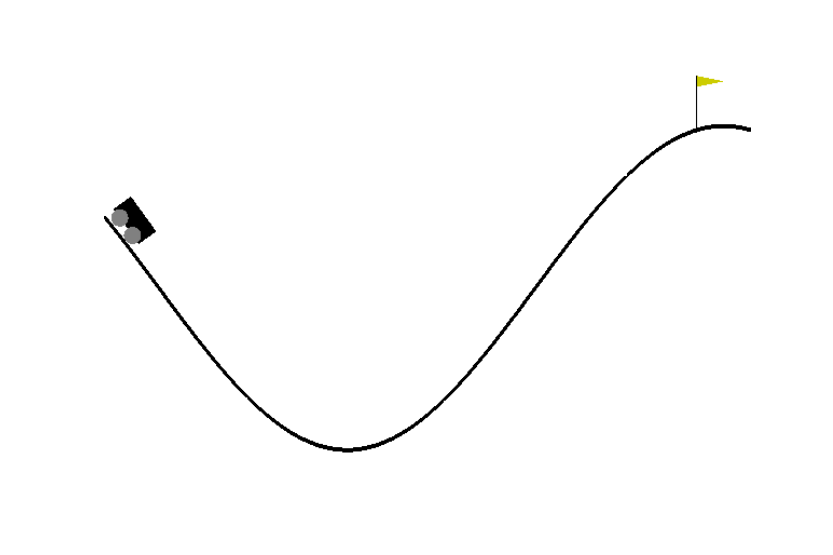
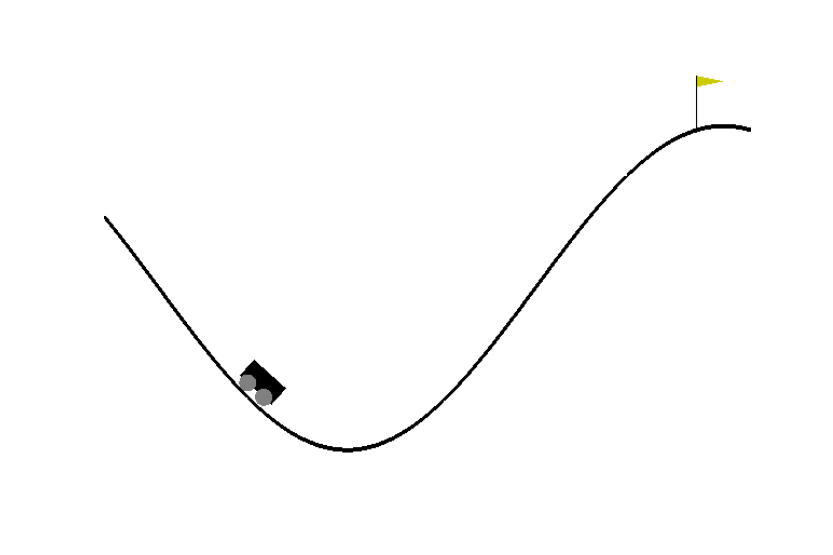
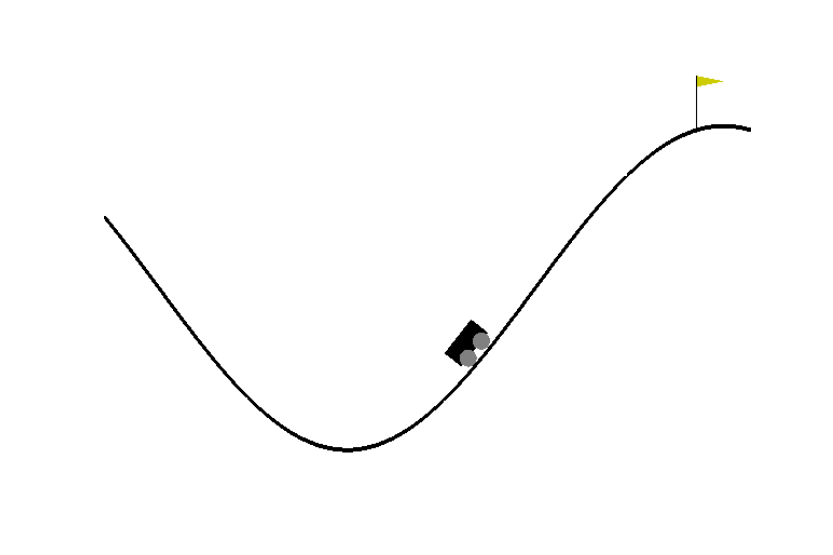
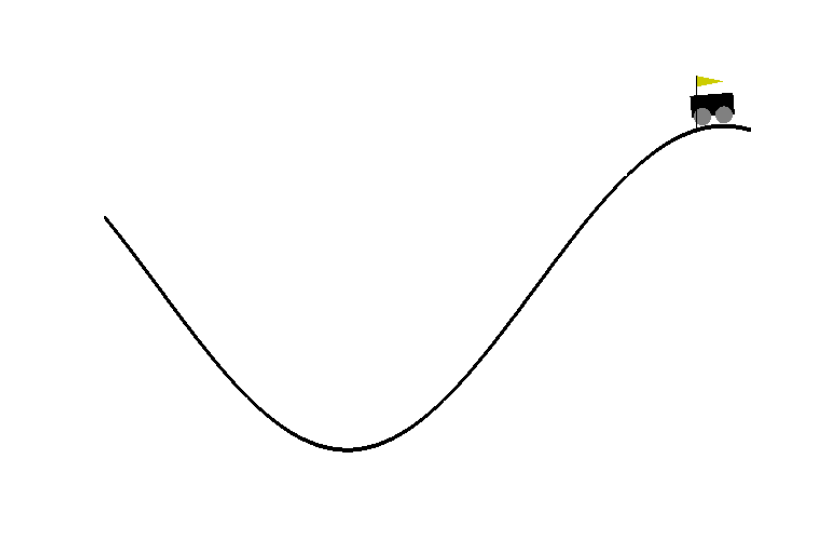
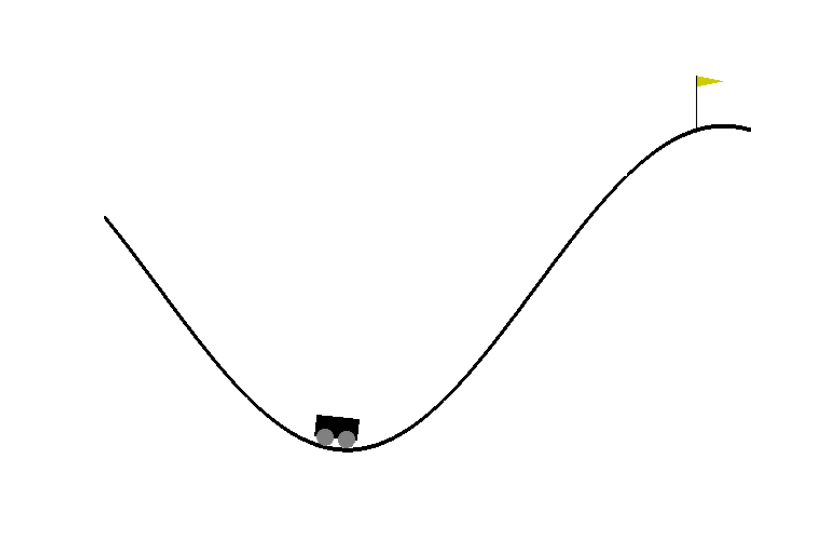
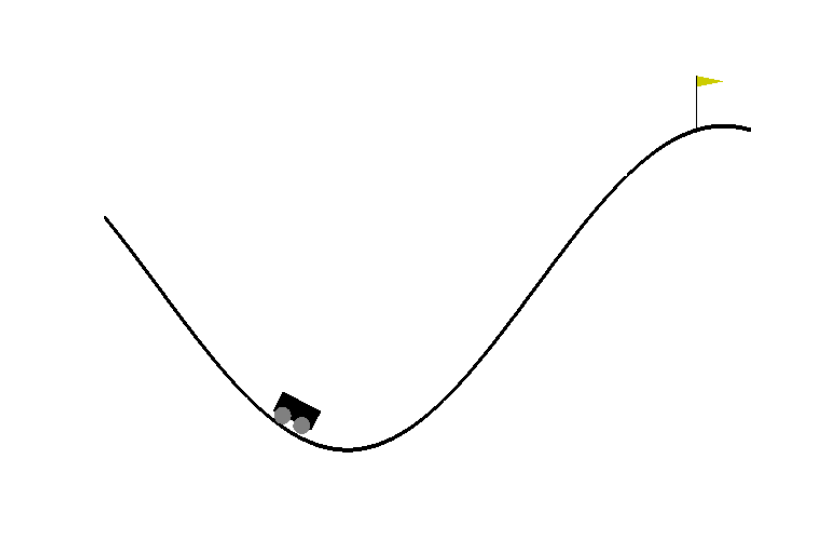
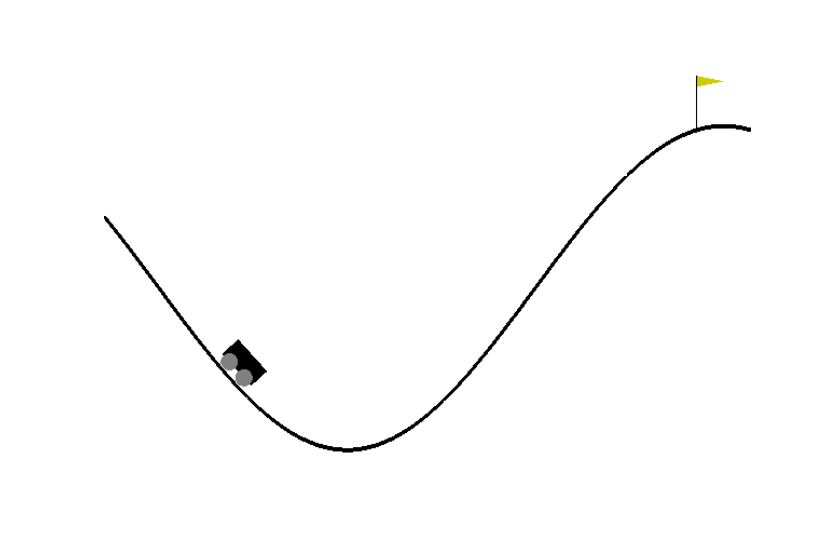

In [23]:
if settings["render_environment"]:
    exp.display_frames_as_gif()

In [24]:
#session.close() 

In [25]:
exp.print_all_tf_variables()

(u'Actor_hidden_0_256_W:0', array([[  3.10449123e-01,  -8.30250323e-01,   9.42699611e-01,
          3.77484947e-01,   4.49805200e-01,  -6.36179745e-01,
          1.15343511e-01,  -6.44223213e-01,   3.69558215e-01,
         -4.33310539e-01,   2.73950487e-01,  -4.33384120e-01,
          4.97410417e-01,  -1.01236284e+00,  -1.06961274e+00,
          8.49069238e-01,   2.02725339e+00,  -6.94160819e-01,
          2.32811853e-01,   8.26460540e-01,  -4.79767799e-01,
          1.45014729e-02,  -9.26192403e-01,  -8.38630021e-01,
         -6.60115004e-01,  -3.48641157e-01,   5.71705520e-01,
         -7.83687830e-01,  -3.79593939e-01,   8.58444273e-01,
          9.39537525e-01,   6.41536236e-01,  -6.52774513e-01,
          2.23633885e+00,   1.42488807e-01,  -1.46013528e-01,
         -5.02676189e-01,   8.99448574e-01,   8.86535048e-02,
         -7.95273423e-01,  -9.53532979e-02,  -3.82327825e-01,
          2.59257585e-01,  -1.67254496e+00,   6.52680218e-01,
         -5.26656657e-02,  -4.46071893e-01